# Using Logistic Regression and Random Forest to determine winning Republican/Democratic candidates in each region of the US

This notebook details the use of both logistic regression and random forest regression to examine which demographic features have the most influence on the predictions.

In [2]:
# Import libraries --------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn
import sklearn.linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from operator import itemgetter

# Suppress warnings -------------
import warnings
warnings.filterwarnings("ignore")

# Function Definitions ----------------------------------------------------------------

In [3]:
# Returns republican winners from each county
def get_winners_republican(cruz, kasich, trump):
    winners = []

    cruz_votes   = cruz["fraction_votes"]
    kasich_votes = kasich["fraction_votes"]
    trump_votes  = trump["fraction_votes"]

    # 0 -- Cruz win
    # 1 -- Kasich win
    # 2 -- Trump win
    for i,j,k in zip(cruz_votes, kasich_votes, trump_votes):
        max_val = max(i,j,k)

        if max_val == i:
            winners.append(0)
        elif max_val == j:
            winners.append(1)
        else:
            winners.append(2)
            
    return winners

In [4]:
# Returns democratic winners from each county
def get_winners_democrat(clinton, sanders):
    winners = []

    clinton_votes = clinton["fraction_votes"]
    sanders_votes = sanders["fraction_votes"]

    # 0 -- Clinton win
    # 1 -- Sanders win
    for i,j in zip(clinton_votes, sanders_votes):
        max_val = max(i,j)

        if max_val == i:
            winners.append(0)
        else:
            winners.append(1)
            
    return winners

In [5]:
# Displays pair plot for winners data
def pair_plot_winners(x, y):
    df = x
    df['winning_candidate'] = np.array([i for i in y])
    sns.pairplot(df, hue='winning_candidate')

In [28]:
# Returns the index of the best feature from a trained random forest model
def rf(x_train, y_train, x_test, y_test, labels, candidates):
    
    # Create random forest model
    rf_model = RandomForestClassifier()
    rf_model.fit(x_train, y_train)
    
    # Get feature importances
    feat_imports = rf_model.feature_importances_

    # Get index of which feature was most important in the classification
    bf_i_1 = max(enumerate(feat_imports), key=itemgetter(1))[0] 
    new_feat_imports = np.delete(feat_imports, bf_i_1) # Remove max to find 2nd best feature's index
    bf_i_2 = max(enumerate(new_feat_imports), key=itemgetter(1))[0] 
 
    # Get best features
    bf_1 = labels[bf_i_1]
    new_labels = np.delete(labels, bf_i_1)
    bf_2 = labels[bf_i_2]
    
    if (bf_1 == bf_2):
        print("ERROR: best features 1 and 2 are the same")
    
    best_features = [bf_1, bf_2]
    
    # Get model's predictions
    predictions = rf_model.predict(x_test)  

    # Print out accuracy and confusion matrix
    print ("Train Accuracy :: ", accuracy_score(y_train, rf_model.predict(x_train)))
    print ("Test Accuracy  :: ", accuracy_score(y_test, predictions))

    # Plot a heatmap of the confusion matrix
    cnf_matrix = sklearn.metrics.confusion_matrix(y_test, predictions)
    sns.heatmap(cnf_matrix, annot=True, fmt="d", cbar=False, square=True, xticklabels=candidates, yticklabels=candidates)
    plt.ylabel("Expected")
    plt.xlabel("Measured")
    plt.title("Confusion Matrix")
    plt.show()
    
    return best_features

In [16]:
# Creates logistic regressor and plots the data
def logistic_regressor_plot(label1, label2, x_train, y_train, x, y, title):
    
    # Create a logistic regressor
    model = sklearn.linear_model.LogisticRegression()

    # "Fit" the logistic regressor to the training set (phase 1)
    # We use only the first two features for visualization purposes
    model.fit(x_train[[label1,label2]], y_train) 

    # Create a grid of the 2D space in which our training data resides
    x_min, x_max = x_train[label1].min() - 0.5, x_train[label1].max() + 0.5
    y_min, y_max = x_train[label2].min() - 0.5, x_train[label2].max() + 0.5
    step_size = 0.02

    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))

    # Use the logistic regressor to classify the entire grid
    preds = model.predict(np.c_[xx.ravel(), yy.ravel()])
    preds = preds.reshape(xx.shape) 

    # Plot the grid of predictions
    plt.figure(1, figsize=(10, 8))
    plt.pcolormesh(xx, yy, preds, cmap=plt.cm.Paired)

    # Plot the dataset using the selected labels
    plt.scatter(x[label1], x[label2], c=y)
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.title(title)
    plt.show()

# Republican Data Analysis ----------------------------------------------------------

In [8]:
# Import county data
county_demo = pd.read_csv('county_facts.csv')
county_demo = county_demo[['fips','area_name','state_abbreviation','PST045214','AGE295214','AGE775214',
                           'SEX255214','RHI225214','RHI725214','RHI825214','EDU635213','EDU685213',
                           'INC110213','PVY020213','POP060210']]
county_demo.rename(columns={'PST045214': 'population', 'AGE295214': 'age < 18', 'AGE775214': 'age > 65','SEX255214': 
                            'female','RHI225214':'black','RHI725214':'latino','RHI825214':'white','EDU635213':'high_school',
                            'EDU685213':'bachelors','INC110213':'med_household','PVY020213':'< poverty_level',
                            'POP060210':'population_psm'}, inplace=True)

# Import primary data
primary_results = pd.read_csv('primary_results.csv')

# Create lists for features and Republican candidates
features = ["age < 18","age > 65","female","black","latino","white","high_school","bachelors","< poverty_level"]

candidates = ["Cruz", "Kasich", "Trump"]

### Southern States

In [8]:
# Get county data for southern states
c = county_demo.state_abbreviation
s_county_demo = county_demo[(c == "NC") | (c == "SC") | (c == "FL") | (c == "GA") | (c == "AL") |
                            (c == "OK") | (c == "TX") | (c == "AR") | (c == "LA")]
county = s_county_demo[features]

# Get desired primary data for southern states
# NOTE: omitted bc there was missing data for some of the counties:
# Virginia (VA)
# Mississippi (MS)
# Kansas (KS)

p = primary_results.state_abbreviation
primary = primary_results[(p == "NC") | (p == "SC") | (p == "FL") | (p == "GA") | (p == "AL") |
                          (p == "OK") | (p == "TX") | (p == "AR") | (p == "LA")]

# Get primary data on Republican votes
pr = primary[primary["party"] == "Republican"]

pr_cruz   = pr[pr["candidate"] == "Ted Cruz"]
pr_kasich = pr[pr["candidate"] == "John Kasich"]
pr_trump  = pr[pr["candidate"] == "Donald Trump"]

# If the candidates' data are not equal in size, there is data missing
if (len(pr_cruz) != len(pr_kasich) or len(pr_kasich) != len(pr_trump) or len(pr_cruz) != len(pr_trump)):
    print("ERROR: missing candidate data")
    print(len(pr_cruz), len(pr_kasich), len(pr_trump))
    
# Get Republican winner from each county
winners = get_winners_republican(pr_cruz, pr_kasich, pr_trump)

# Check that county data size matches the winners data size
if (len(county) != len(winners)):
    print("ERROR: missing county or winners data")
    print(len(county), len(winners))

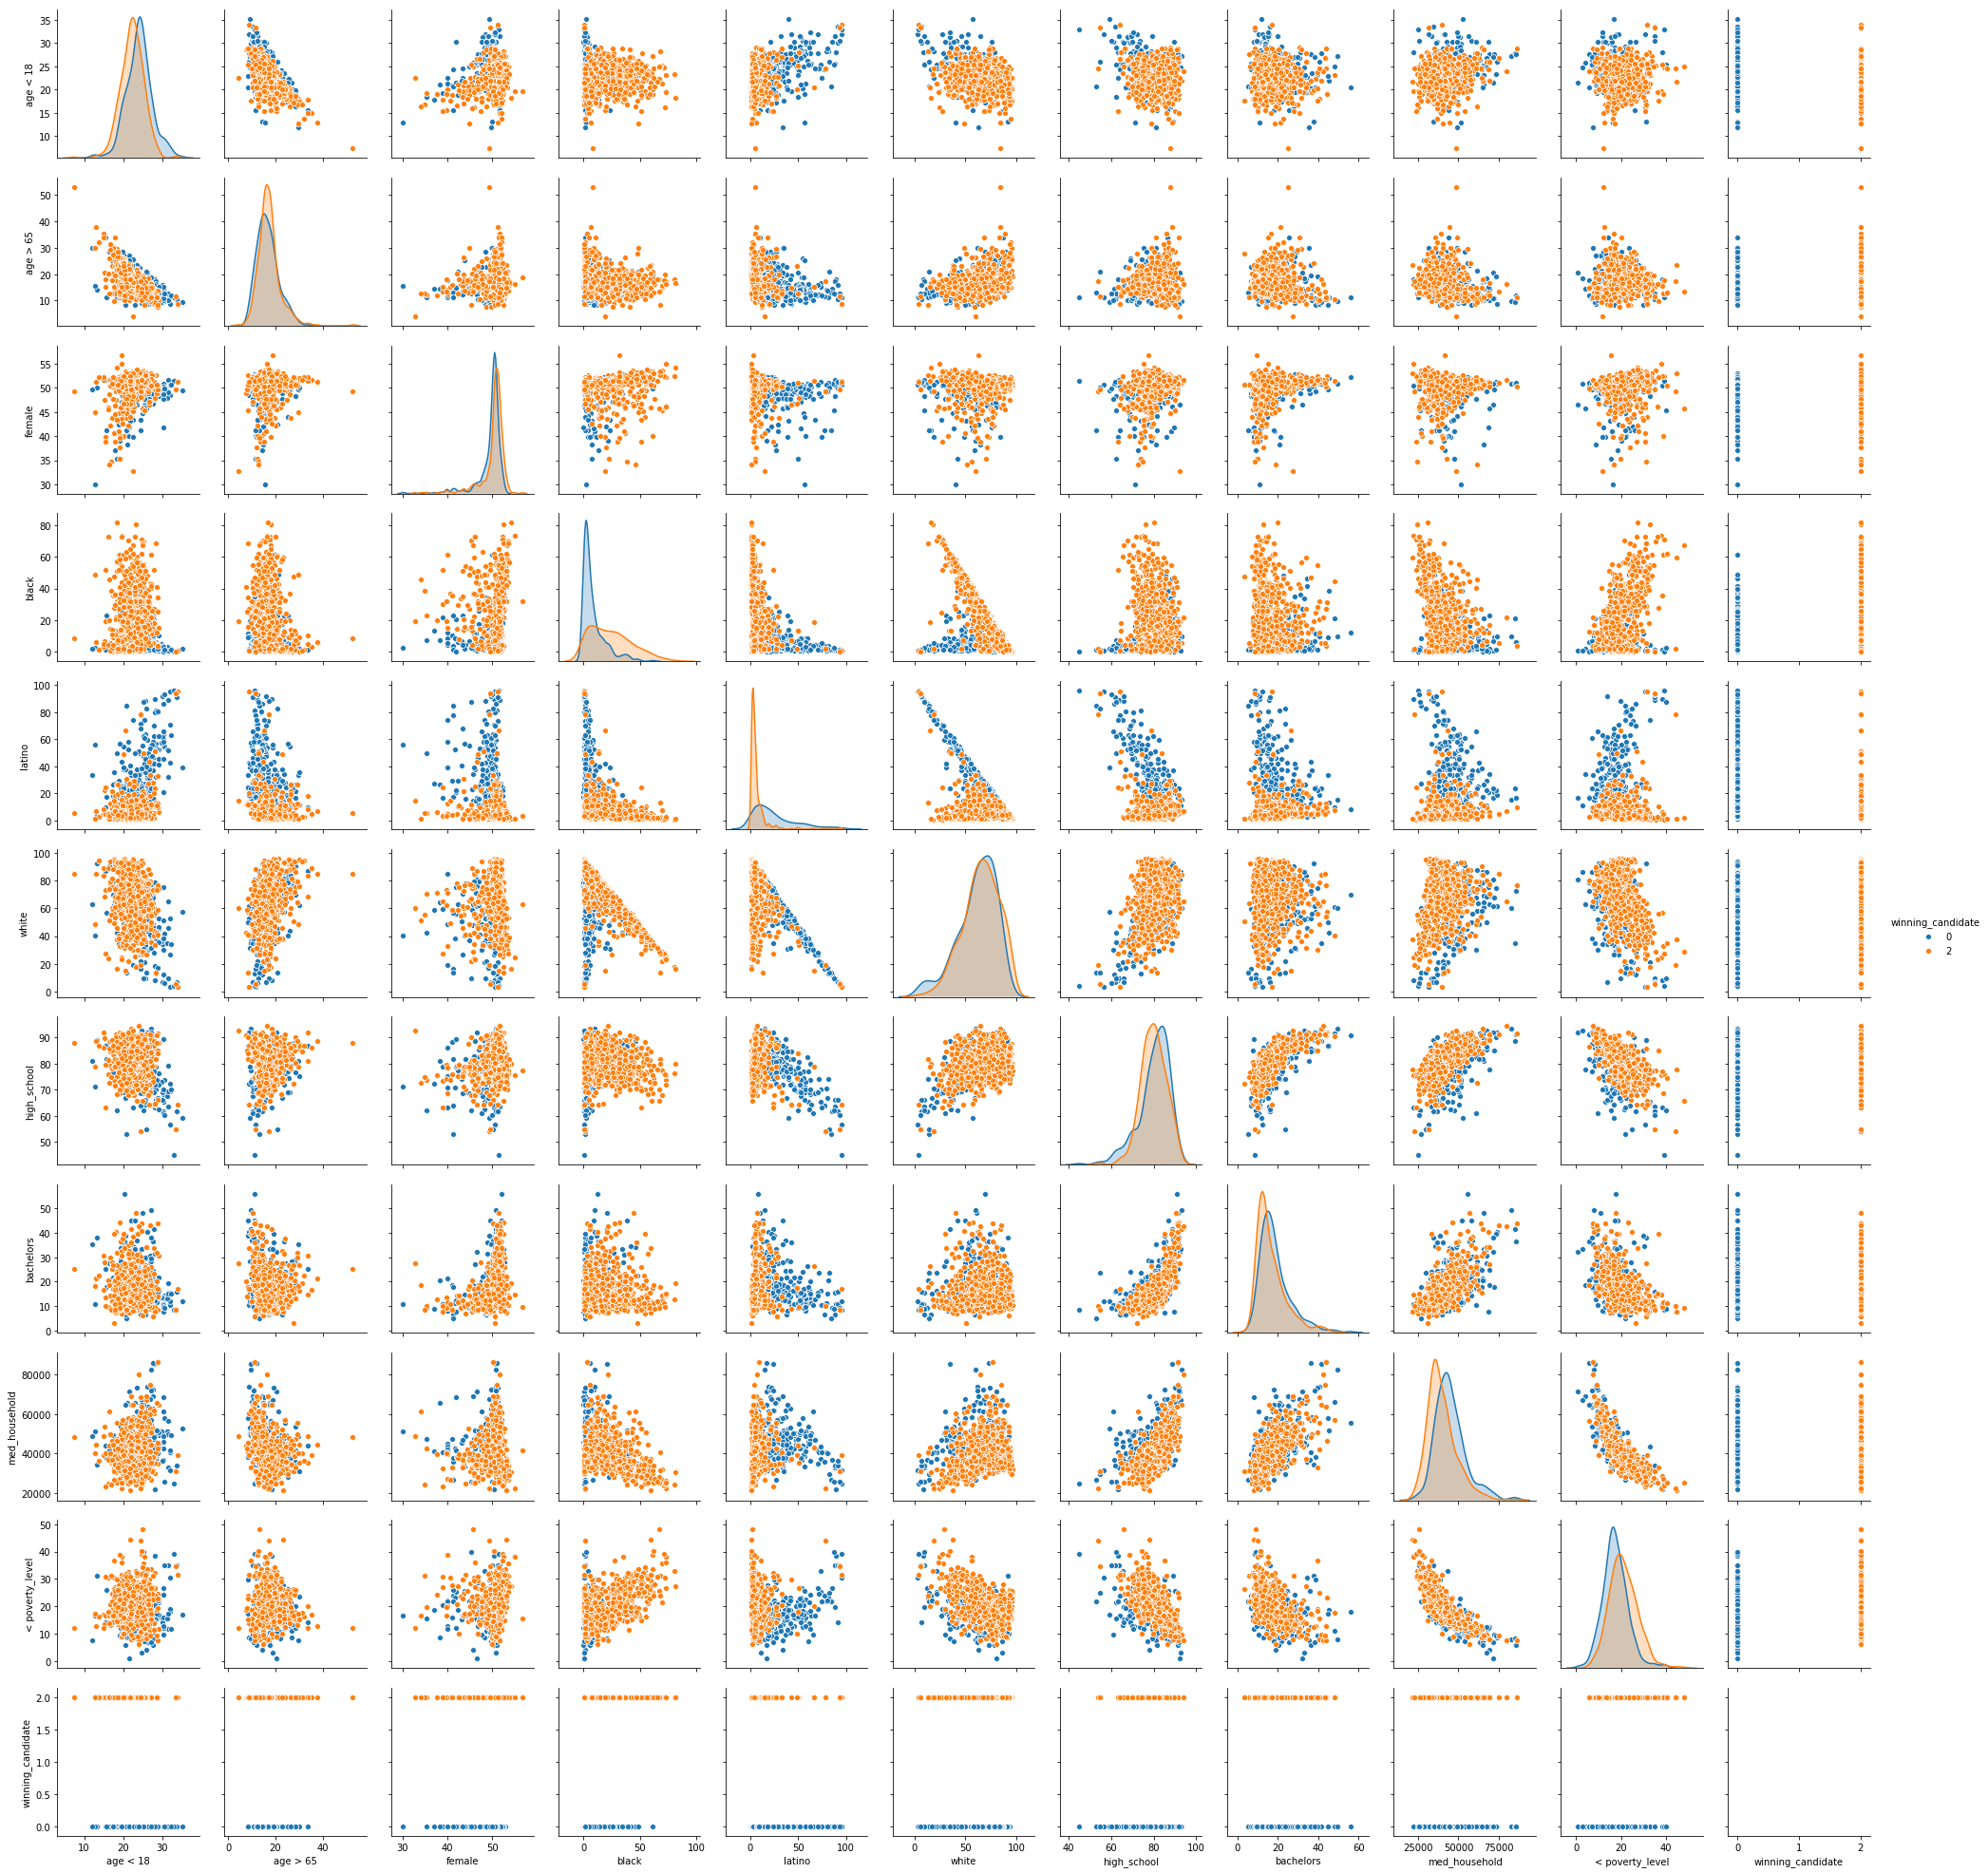

In [9]:
# Create train and test sets for Republican data
r_x = county
r_y = winners
r_x_train, r_x_test, r_y_train, r_y_test = sklearn.model_selection.train_test_split(r_x, r_y, test_size=0.3)

# Show pair plot for Republican winners
pair_plot_winners(r_x, r_y)

Train Accuracy ::  0.9889937106918238
Test Accuracy  ::  0.8241758241758241


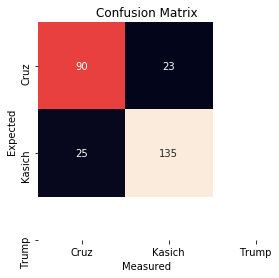

In [10]:
# Create random forest model and get best feature
bf = rf(r_x_train, r_y_train, r_x_test, r_y_test, features, candidates)

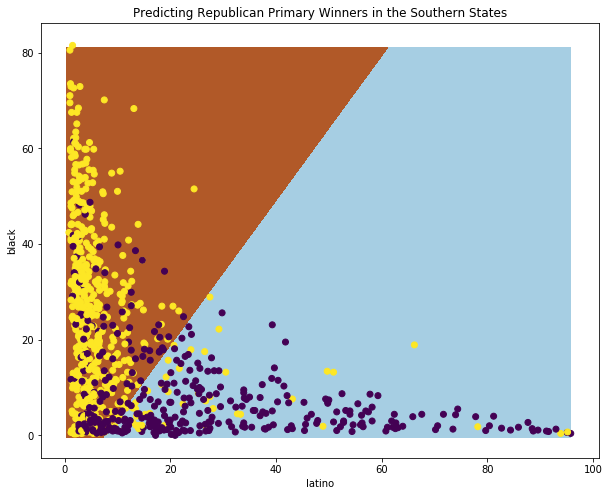

In [11]:
# Create a logistic regressor to show how the model "sees" the data
# Plot data on the two best features
r_title = "Predicting Republican Primary Winners in the Southern States"
logistic_regressor_plot(bf[0], bf[1], r_x_train, r_y_train, r_x, r_y, r_title)

### Northeastern States

In [12]:
# Get county data for northeastern states
c = county_demo.state_abbreviation
ne_county_demo = county_demo[(c == "DE") | (c == "MD") | (c == "NH") | (c == "NJ") | (c == "NY") | (c == "PA")]
county = ne_county_demo[features]

# Get desired primary data for northeastern states
# NOTE: omitted bc there was missing data for some of the counties:
# Connecticut (CT)
# Maryland (ME)
# Massachusetts (MA)
# Rhode Island (RI)
# Vermont (VT)

p = primary_results.state_abbreviation
primary = primary_results[(p == "DE") | (p == "MD") | (p == "NH") | (p == "NJ") | (p == "NY") | (p == "PA")]

# Get primary data on Republican votes
pr = primary[primary["party"] == "Republican"]

pr_cruz   = pr[pr["candidate"] == "Ted Cruz"]
pr_kasich = pr[pr["candidate"] == "John Kasich"]
pr_trump  = pr[pr["candidate"] == "Donald Trump"]

# If the candidates' data are not equal in size, there is data missing
if (len(pr_cruz) != len(pr_kasich) or len(pr_kasich) != len(pr_trump) or len(pr_cruz) != len(pr_trump)):
    print("ERROR: missing candidate data")
    print(len(pr_cruz), len(pr_kasich), len(pr_trump))
    
# Get Republican winner from each county
winners = get_winners_republican(pr_cruz, pr_kasich, pr_trump)

# Check that county data size matches the winners data size
if (len(county) != len(winners)):
    print("ERROR: missing county or winners data")
    print(len(county), len(winners))

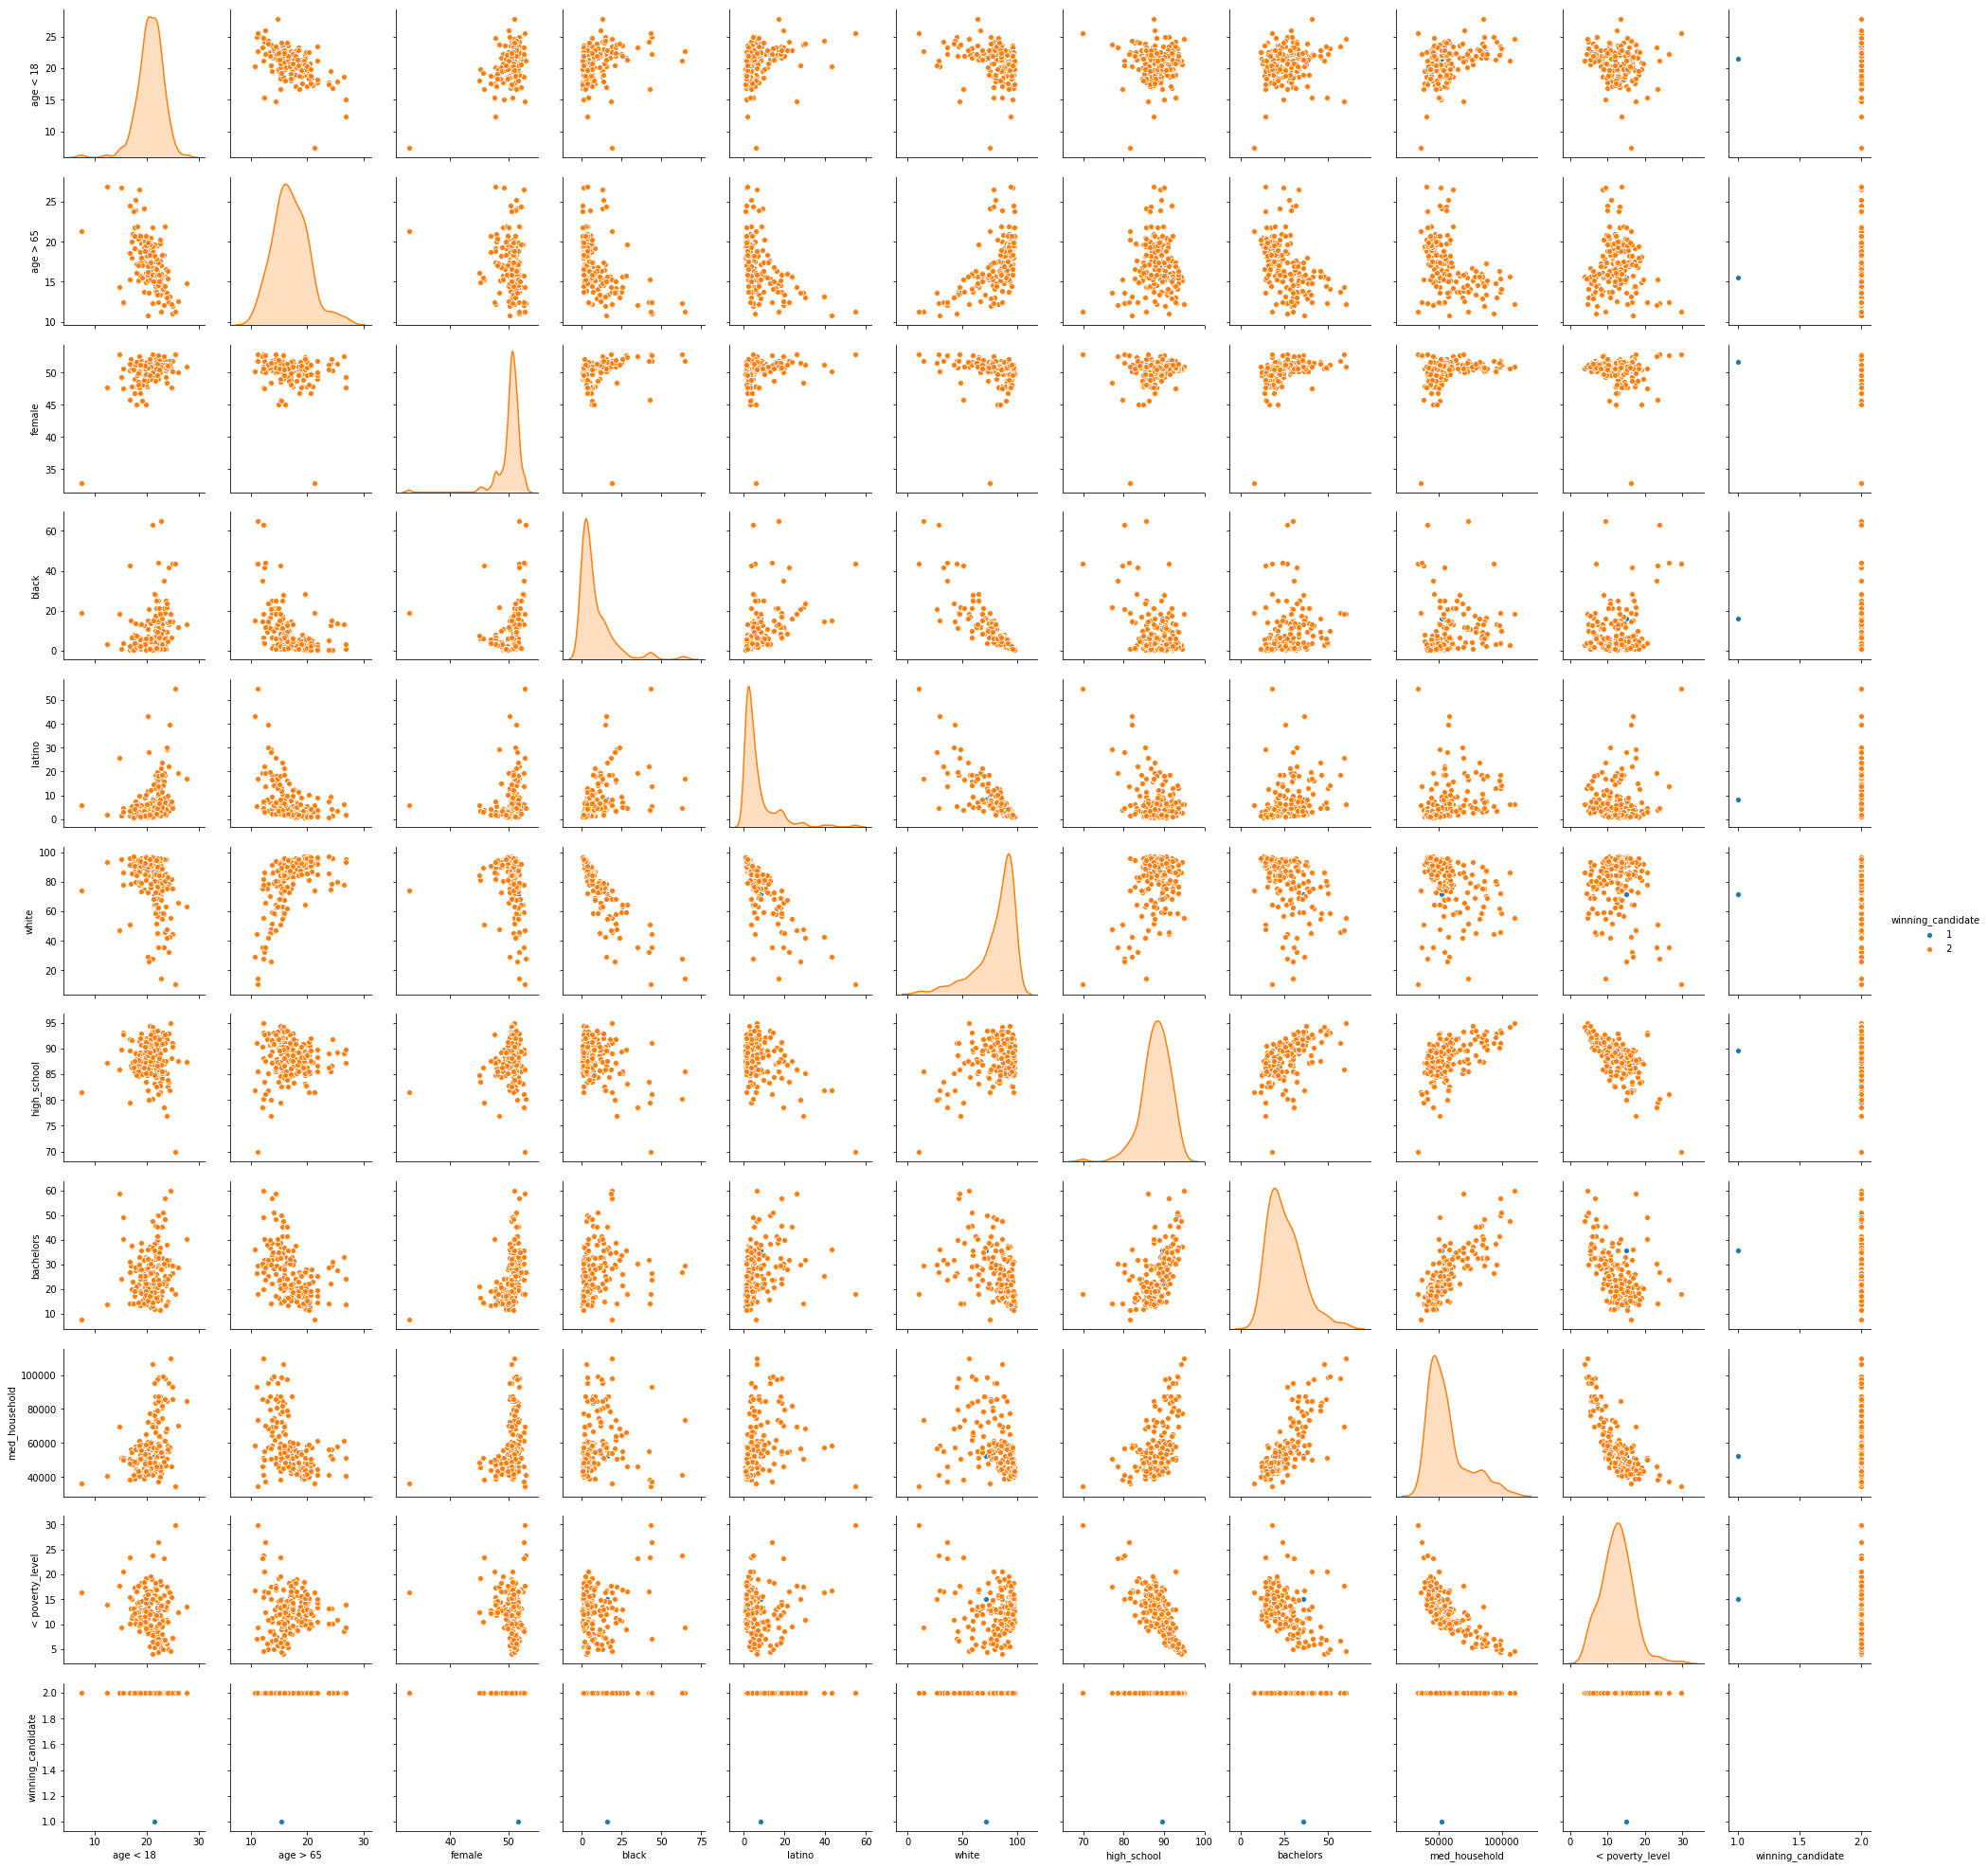

In [13]:
# Create train and test sets for Republican data
r_x = county
r_y = winners
r_x_train, r_x_test, r_y_train, r_y_test = sklearn.model_selection.train_test_split(r_x, r_y, test_size=0.3)

# Show pair plot for Republican winners
pair_plot_winners(r_x, r_y)

Train Accuracy ::  1.0
Test Accuracy  ::  1.0


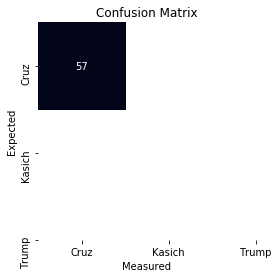

In [14]:
# Create random forest model and get best feature
bf = rf(r_x_train, r_y_train, r_x_test, r_y_test, features, candidates)

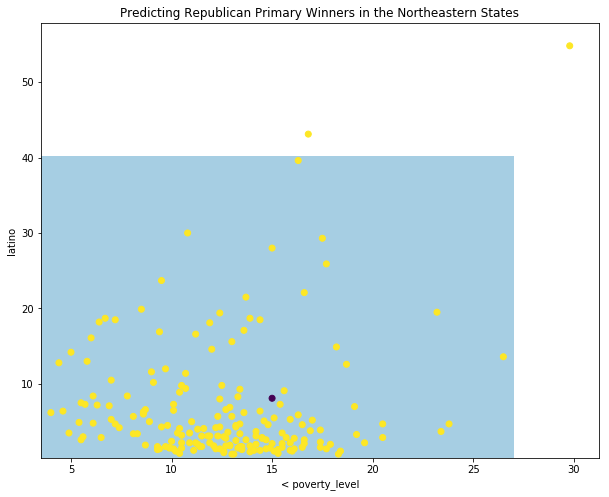

In [15]:
# Create a logistic regressor to show how the model "sees" the data
# Plot data on the two best features
r_title = "Predicting Republican Primary Winners in the Northeastern States"
logistic_regressor_plot(bf[0], bf[1], r_x_train, r_y_train, r_x, r_y, r_title)

### Midwestern States

In [9]:
# Get county data for midwestern states
c = county_demo.state_abbreviation
mw_county_demo = county_demo[(c == "IN") | (c == "IA") | (c == "MI") | (c == "MO") | (c == "NE") | 
                             (c == "OH") | (c == "SD") | (c == "WI") | (c == "WV")]
county = mw_county_demo[features]

# Get desired primary data for midwestern states
# NOTE: omitted bc there was missing data for some of the counties:
# Illinois (IL)
# Minnesota (MN)
# North Dakota (ND)

p = primary_results.state_abbreviation
primary = primary_results[(p == "IN") | (p == "IA") | (p == "MI") | (p == "MO") | (p == "NE") | 
                          (p == "OH") | (p == "SD") | (p == "WI") | (p == "WV")]

# Get primary data on Republican votes
pr = primary[primary["party"] == "Republican"]

pr_cruz   = pr[pr["candidate"] == "Ted Cruz"]
pr_kasich = pr[pr["candidate"] == "John Kasich"]
pr_trump  = pr[pr["candidate"] == "Donald Trump"]

# If the candidates' data are not equal in size, there is data missing
if (len(pr_cruz) != len(pr_kasich) or len(pr_kasich) != len(pr_trump) or len(pr_cruz) != len(pr_trump)):
    print("ERROR: missing candidate data")
    print(len(pr_cruz), len(pr_kasich), len(pr_trump))
    
# Get Republican winner from each county
winners = get_winners_republican(pr_cruz, pr_kasich, pr_trump)

# Check that county data size matches the winners data size
if (len(county) != len(winners)):
    print("ERROR: missing county or winners data")
    print(len(county), len(winners))

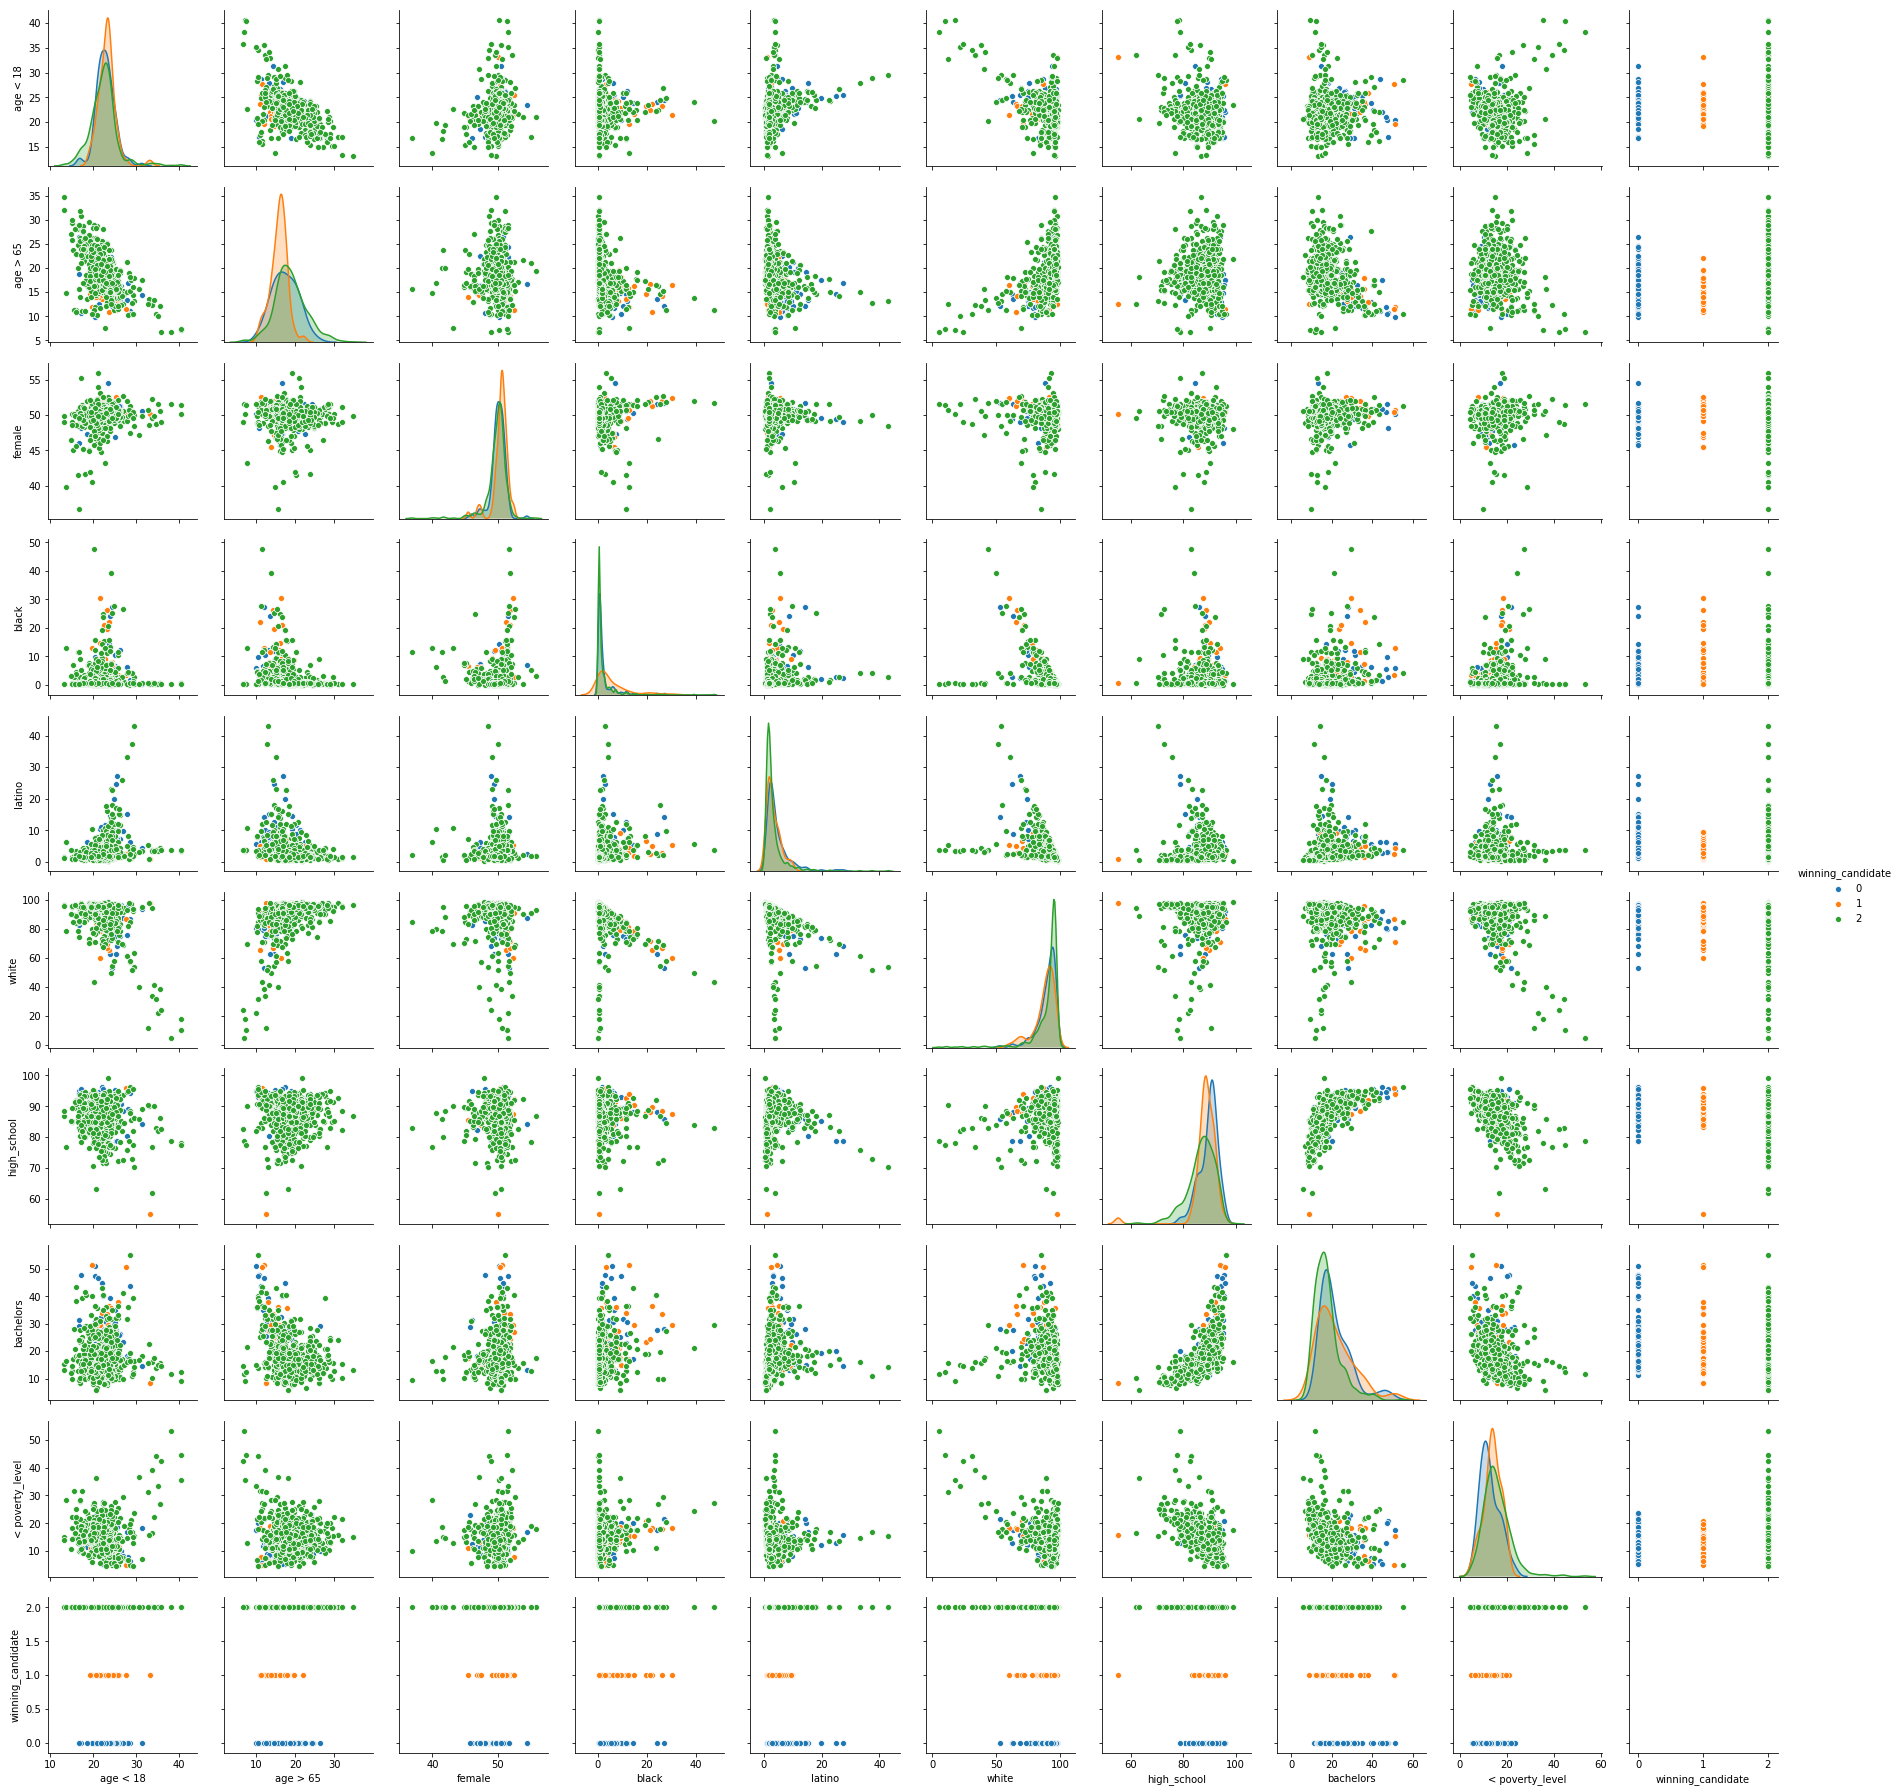

In [10]:
# Create train and test sets for Republican data
r_x = county
r_y = winners
r_x_train, r_x_test, r_y_train, r_y_test = sklearn.model_selection.train_test_split(r_x, r_y, test_size=0.3)

# Show pair plot for Republican winners
pair_plot_winners(r_x, r_y)

Train Accuracy ::  0.9812734082397003
Test Accuracy  ::  0.7510917030567685


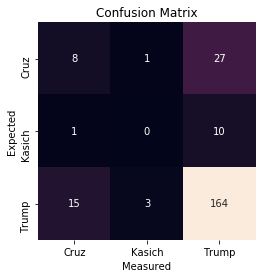

['age > 65', 'high_school']


In [17]:
# Create random forest model and get best feature
bf = rf(r_x_train, r_y_train, r_x_test, r_y_test, features, candidates)
print(bf)

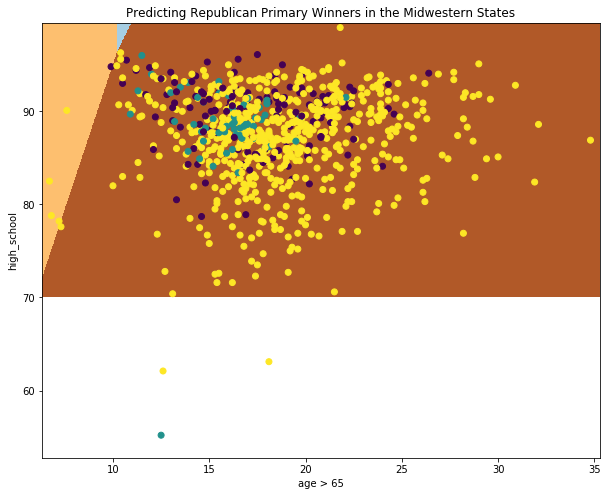

In [18]:
# Create a logistic regressor to show how the model "sees" the data
# Plot data on the two best features
r_title = "Predicting Republican Primary Winners in the Midwestern States"
logistic_regressor_plot(bf[0], bf[1], r_x_train, r_y_train, r_x, r_y, r_title)

### Western States

In [19]:
# Get county data for western states
c = county_demo.state_abbreviation
w_county_demo = county_demo[(c == "AZ") | (c == "CA") | (c == "ID") | (c == "MT") | (c == "NV") | 
                            (c == "NM") | (c == "OR") | (c == "UT") | (c == "WA")]
county = w_county_demo[features]

# Get desired primary data for western states
# NOTE: omitted bc there was missing data for some of the counties:
# Alaska (AK)
# Colorado (CO)
# Hawaii (HI)
# Wyoming (WY)

p = primary_results.state_abbreviation
primary = primary_results[(p == "AZ") | (p == "CA") | (p == "ID") | (p == "MT") | (p == "NV") | 
                          (p == "NM") | (p == "OR") | (p == "UT") | (p == "WA")]

# Get primary data on Republican votes
pr = primary[primary["party"] == "Republican"]

pr_cruz   = pr[pr["candidate"] == "Ted Cruz"]
pr_kasich = pr[pr["candidate"] == "John Kasich"]
pr_trump  = pr[pr["candidate"] == "Donald Trump"]

# If the candidates' data are not equal in size, there is data missing
if (len(pr_cruz) != len(pr_kasich) or len(pr_kasich) != len(pr_trump) or len(pr_cruz) != len(pr_trump)):
    print("ERROR: missing candidate data")
    print(len(pr_cruz), len(pr_kasich), len(pr_trump))
    
# Get Republican winner from each county
winners = get_winners_republican(pr_cruz, pr_kasich, pr_trump)

# Check that county data size matches the winners data size
if (len(county) != len(winners)):
    print("ERROR: missing county or winners data")
    print(len(county), len(winners))

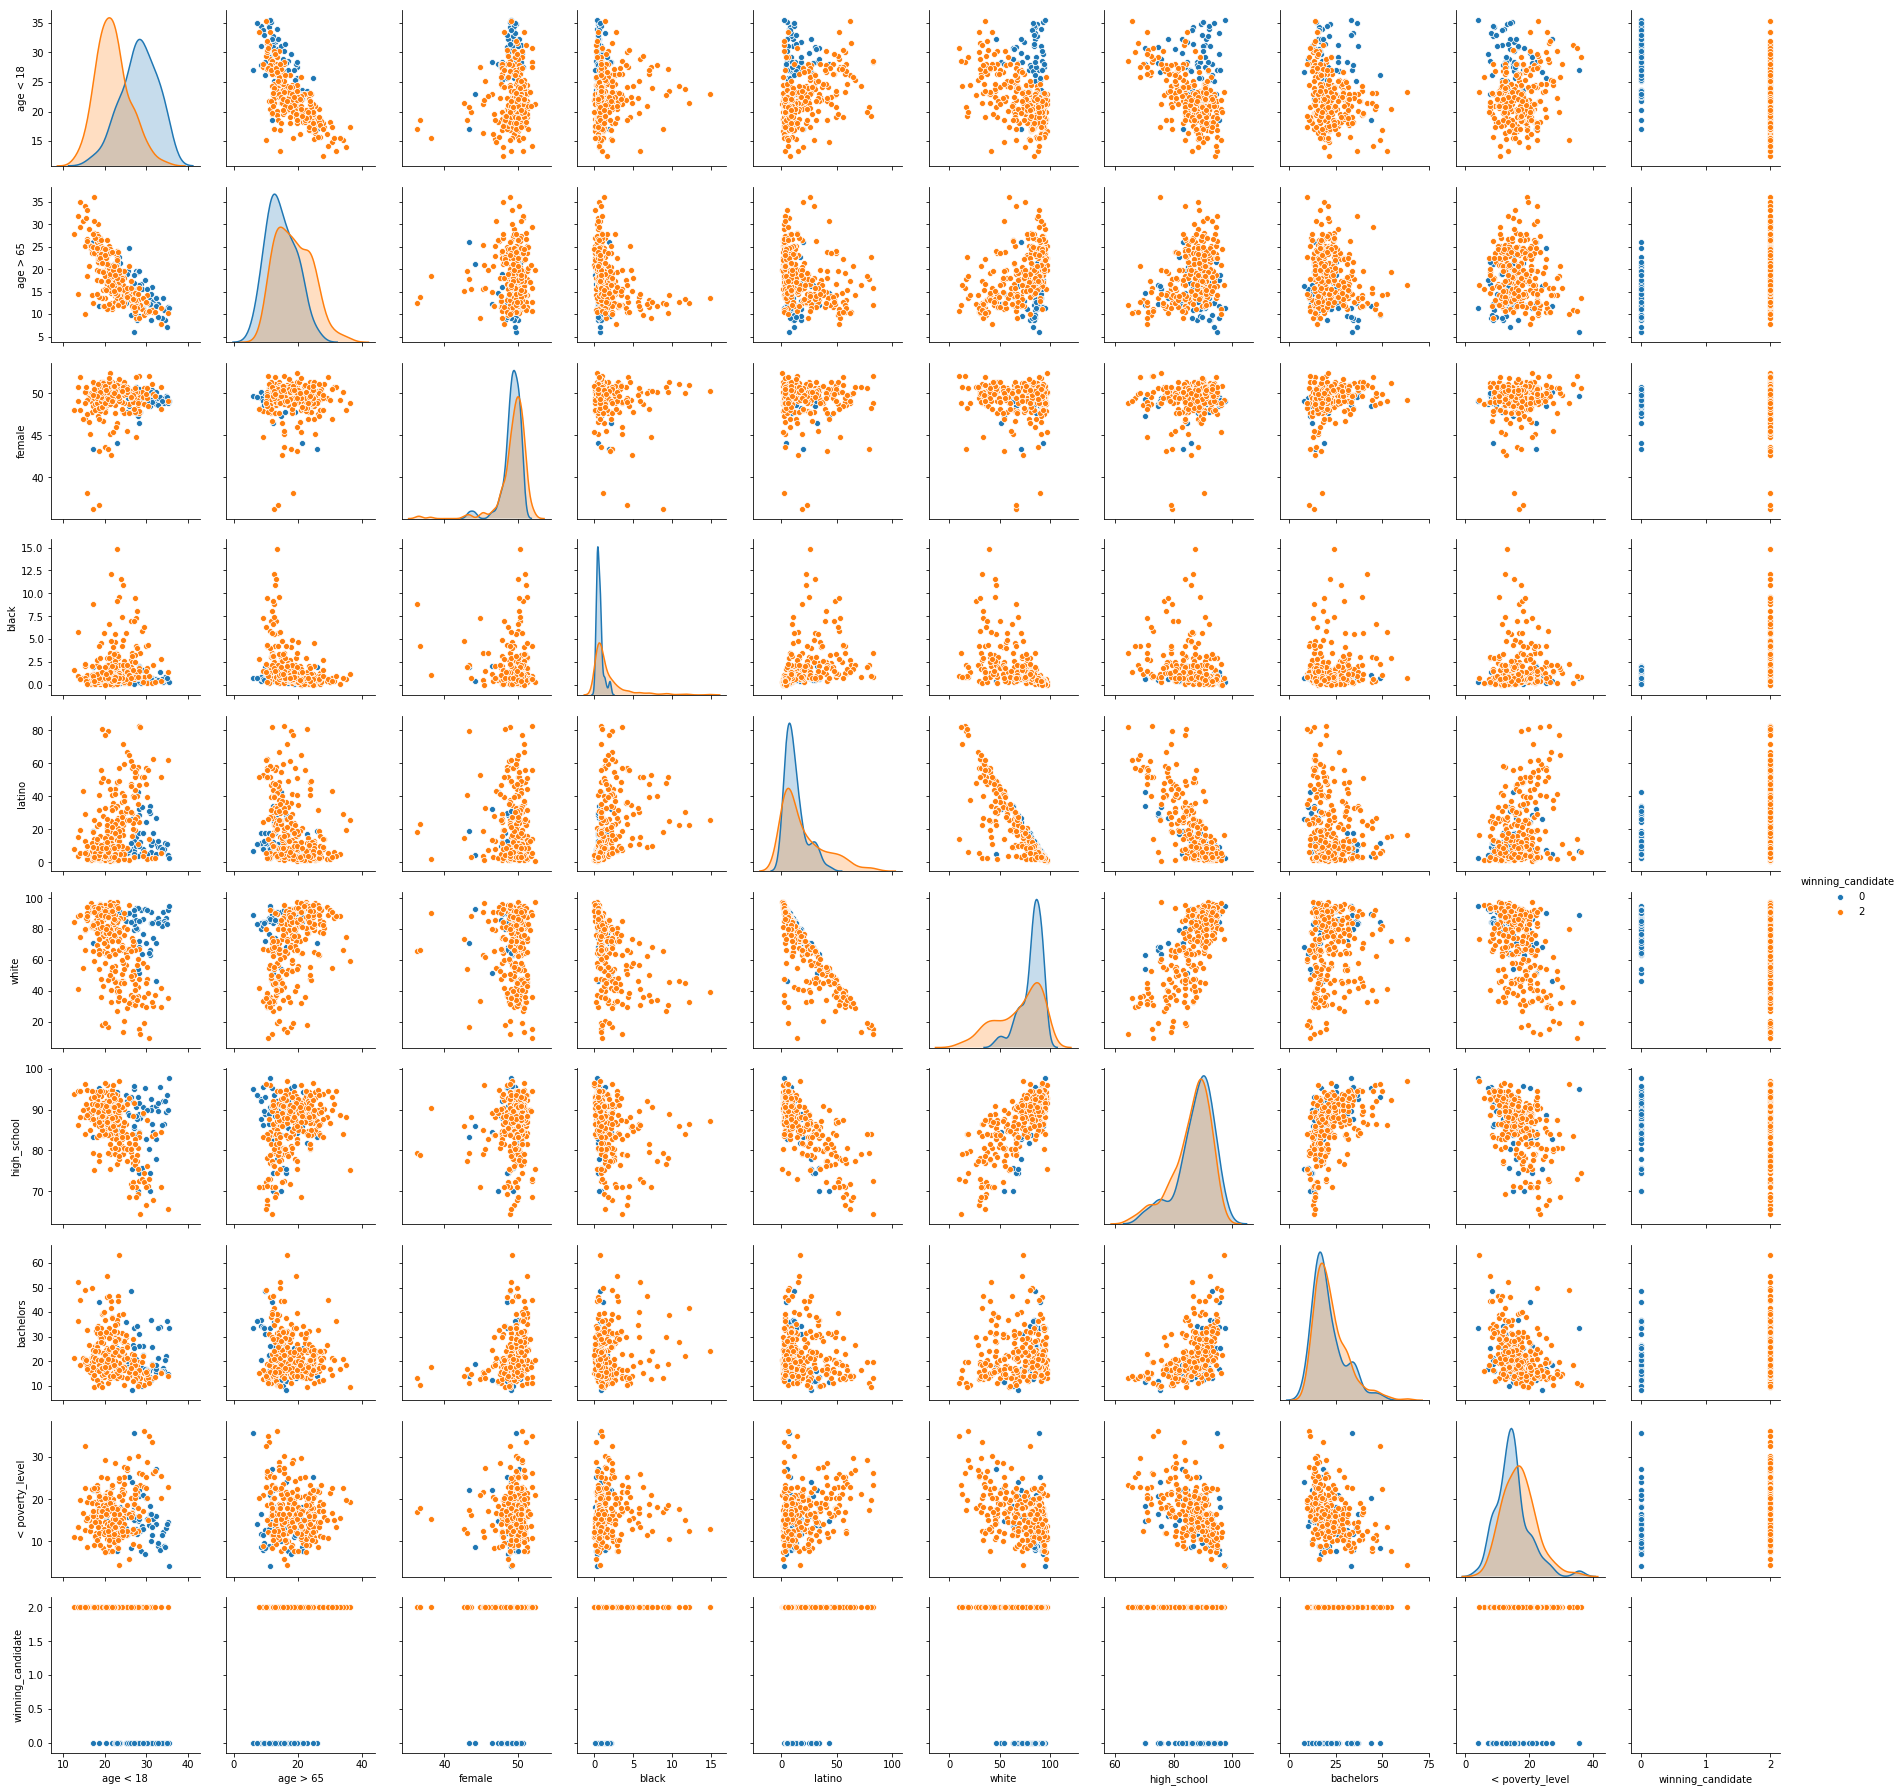

In [20]:
# Create train and test sets for Republican data
r_x = county
r_y = winners
r_x_train, r_x_test, r_y_train, r_y_test = sklearn.model_selection.train_test_split(r_x, r_y, test_size=0.3)

# Show pair plot for Republican winners
pair_plot_winners(r_x, r_y)

Train Accuracy ::  1.0
Test Accuracy  ::  0.9090909090909091


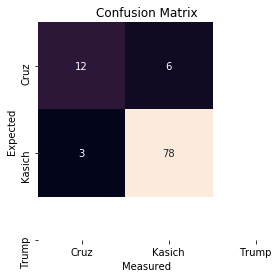

In [21]:
# Create random forest model and get best feature
bf = rf(r_x_train, r_y_train, r_x_test, r_y_test, features, candidates)

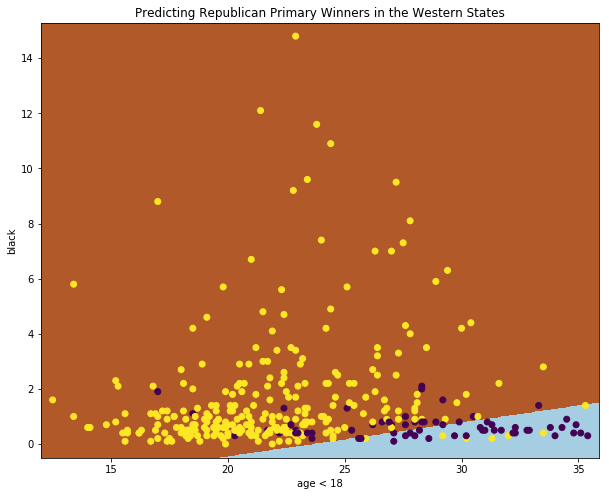

In [22]:
# Create a logistic regressor to show how the model "sees" the data
# Plot data on the two best features
r_title = "Predicting Republican Primary Winners in the Western States"
logistic_regressor_plot(bf[0], bf[1], r_x_train, r_y_train, r_x, r_y, r_title)

# Democratic Data Analysis ---------------------------------------------------------

In [23]:
# Import county data
county_demo = pd.read_csv('county_facts.csv')
county_demo = county_demo[['fips','area_name','state_abbreviation','PST045214','AGE295214','AGE775214',
                           'SEX255214','RHI225214','RHI725214','RHI825214','EDU635213','EDU685213',
                           'INC110213','PVY020213','POP060210']]
county_demo.rename(columns={'PST045214': 'population', 'AGE295214': 'age < 18', 'AGE775214': 'age > 65','SEX255214': 
                            'female','RHI225214':'black','RHI725214':'latino','RHI825214':'white','EDU635213':'high_school',
                            'EDU685213':'bachelors','INC110213':'med_household','PVY020213':'< poverty_level',
                            'POP060210':'population_psm'}, inplace=True)

# Import primary data
primary_results = pd.read_csv('primary_results.csv')

# Create lists for features and Democratic candidates
features = ["age < 18","age > 65","female","black","latino","white","high_school","bachelors",
            "< poverty_level"]

candidates = ["Clinton", "Sanders"]

### Southern States

In [36]:
# Get county data for southern states
c = county_demo.state_abbreviation
s_county_demo = county_demo[(c == "NC") | (c == "SC") | (c == "FL") | (c == "GA") | (c == "AL") |
                            (c == "OK") | (c == "TX") | (c == "AR") | (c == "LA")]
county = s_county_demo[features]

# Get desired primary data for southern states
# NOTE: omitted bc there was missing data for some of the counties:
# Virginia (VA)
# Mississippi (MS)
# Kansas (KS)

p = primary_results.state_abbreviation
primary = primary_results[(p == "NC") | (p == "SC") | (p == "FL") | (p == "GA") | (p == "AL") |
                          (p == "OK") | (p == "TX") | (p == "AR") | (p == "LA")]

# Get primary data on Democratic votes
pr = primary[primary["party"] == "Democrat"]

pr_clinton   = pr[pr["candidate"] == "Hillary Clinton"]
pr_sanders = pr[pr["candidate"] == "Bernie Sanders"]

# If the candidates' data are not equal in size, there is data missing
if (len(pr_clinton) != len(pr_sanders)):
    print("ERROR: missing candidate data")
    print(len(pr_clinton), len(pr_sanders))
    
# Get Republican winner from each county
winners = get_winners_democrat(pr_clinton, pr_sanders)

# Check that county data size matches the winners data size
if (len(county) != len(winners)):
    print("ERROR: missing county or winners data")
    print(len(county), len(winners))

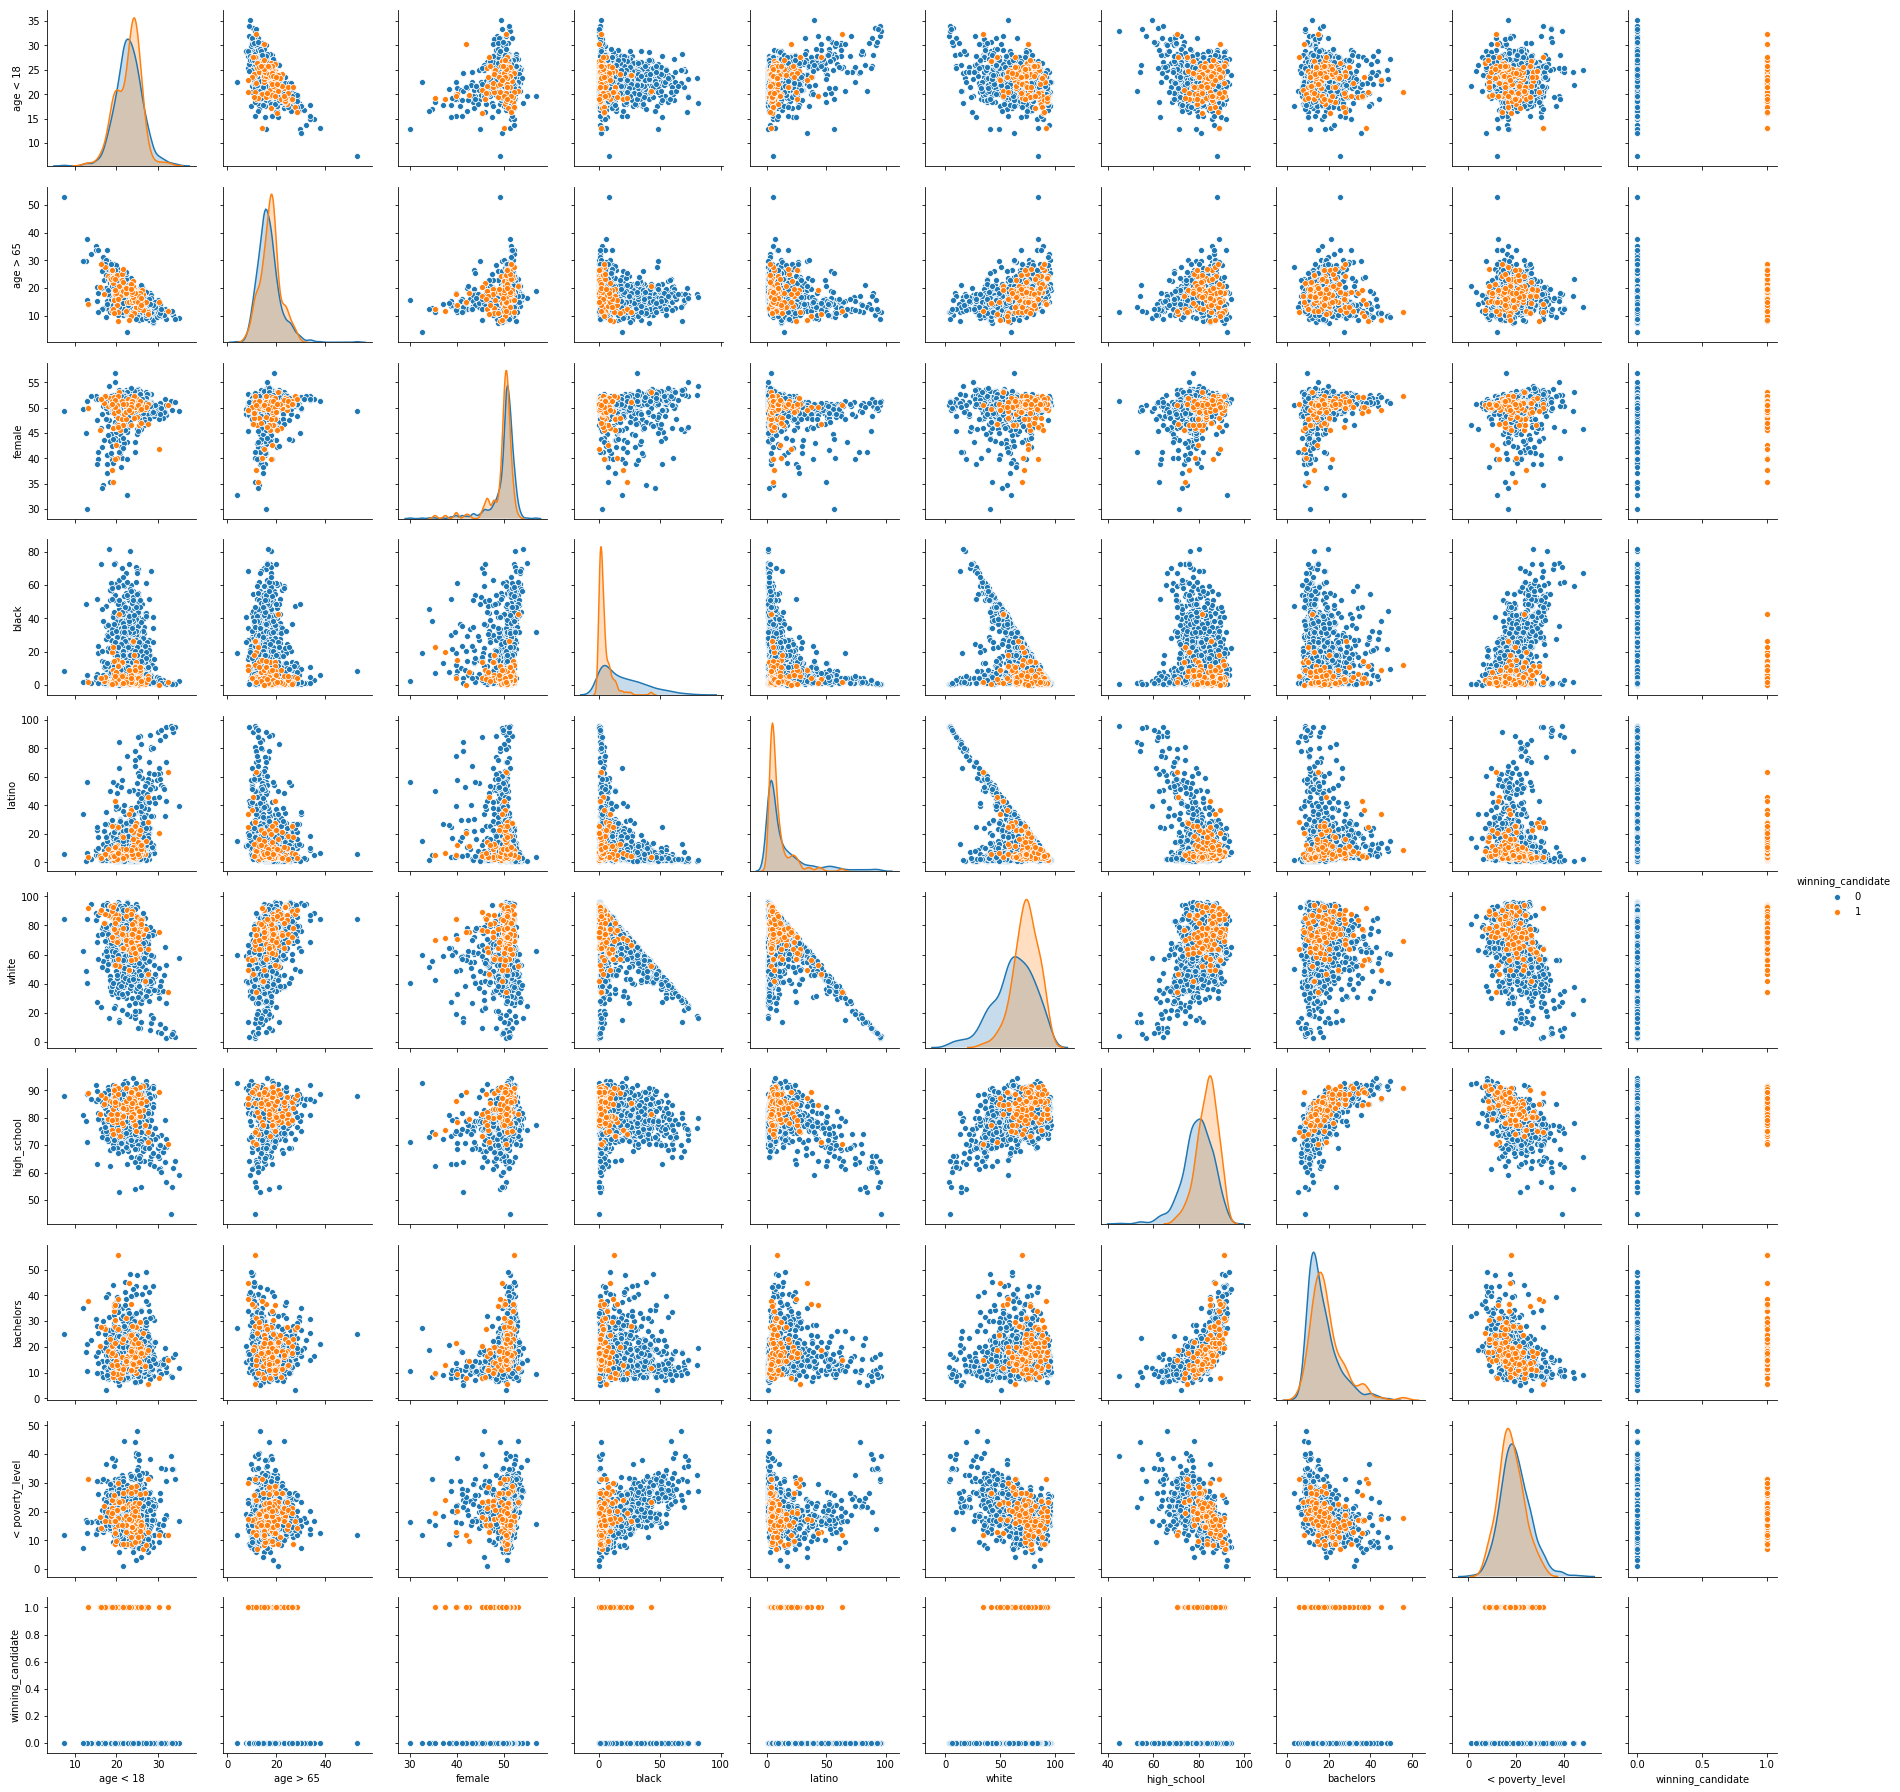

In [37]:
# Create train and test sets for Democratic data
d_x = county
d_y = winners
d_x_train, d_x_test, d_y_train, d_y_test = sklearn.model_selection.train_test_split(d_x, d_y, test_size=0.3)

# Show pair plot for Democratic winners
pair_plot_winners(d_x, d_y)

Train Accuracy ::  0.9874213836477987
Test Accuracy  ::  0.8827838827838828


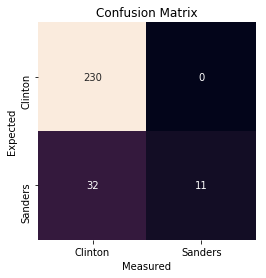

In [38]:
# Create random forest model and get best feature
bf = rf(d_x_train, d_y_train, d_x_test, d_y_test, features, candidates)

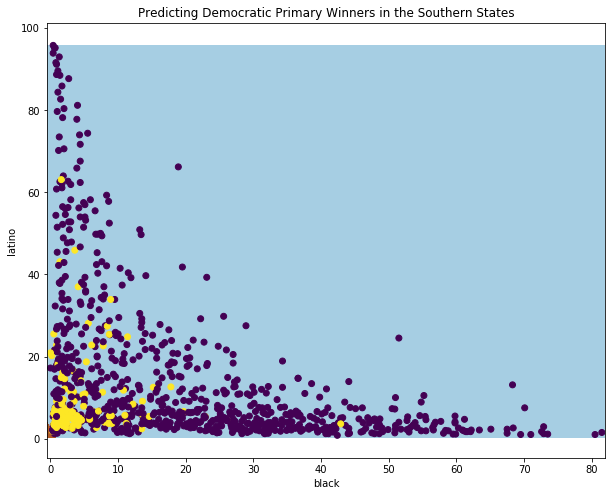

In [39]:
# Create a logistic regressor to show how the model "sees" the data
# Plot data on the two best features
d_title = "Predicting Democratic Primary Winners in the Southern States"
logistic_regressor_plot(bf[0], bf[1], d_x_train, d_y_train, d_x, d_y, d_title)

### Northeastern States

In [40]:
# Get county data for northeastern states
c = county_demo.state_abbreviation
ne_county_demo = county_demo[(c == "DE") | (c == "MD") | (c == "NH") | (c == "NJ") | (c == "NY") | (c == "PA")]
county = ne_county_demo[features]

# Get desired primary data for northeastern states
# NOTE: omitted bc there was missing data for some of the counties:
# Connecticut (CT)
# Maryland (ME)
# Massachusetts (MA)
# Rhode Island (RI)
# Vermont (VT)

p = primary_results.state_abbreviation
primary = primary_results[(p == "DE") | (p == "MD") | (p == "NH") | (p == "NJ") | (p == "NY") | (p == "PA")]

# Get primary data on Democratic votes
pr = primary[primary["party"] == "Democrat"]

pr_clinton = pr[pr["candidate"] == "Hillary Clinton"]
pr_sanders = pr[pr["candidate"] == "Bernie Sanders"]

# If the candidates' data are not equal in size, there is data missing
if (len(pr_clinton) != len(pr_sanders)):
    print("ERROR: missing candidate data")
    print(len(pr_clinton), len(pr_sanders))
    
# Get Democratic winner from each county
winners = get_winners_democrat(pr_clinton, pr_sanders)

# Check that county data size matches the winners data size
if (len(county) != len(winners)):
    print("ERROR: missing county or winners data")
    print(len(county), len(winners))

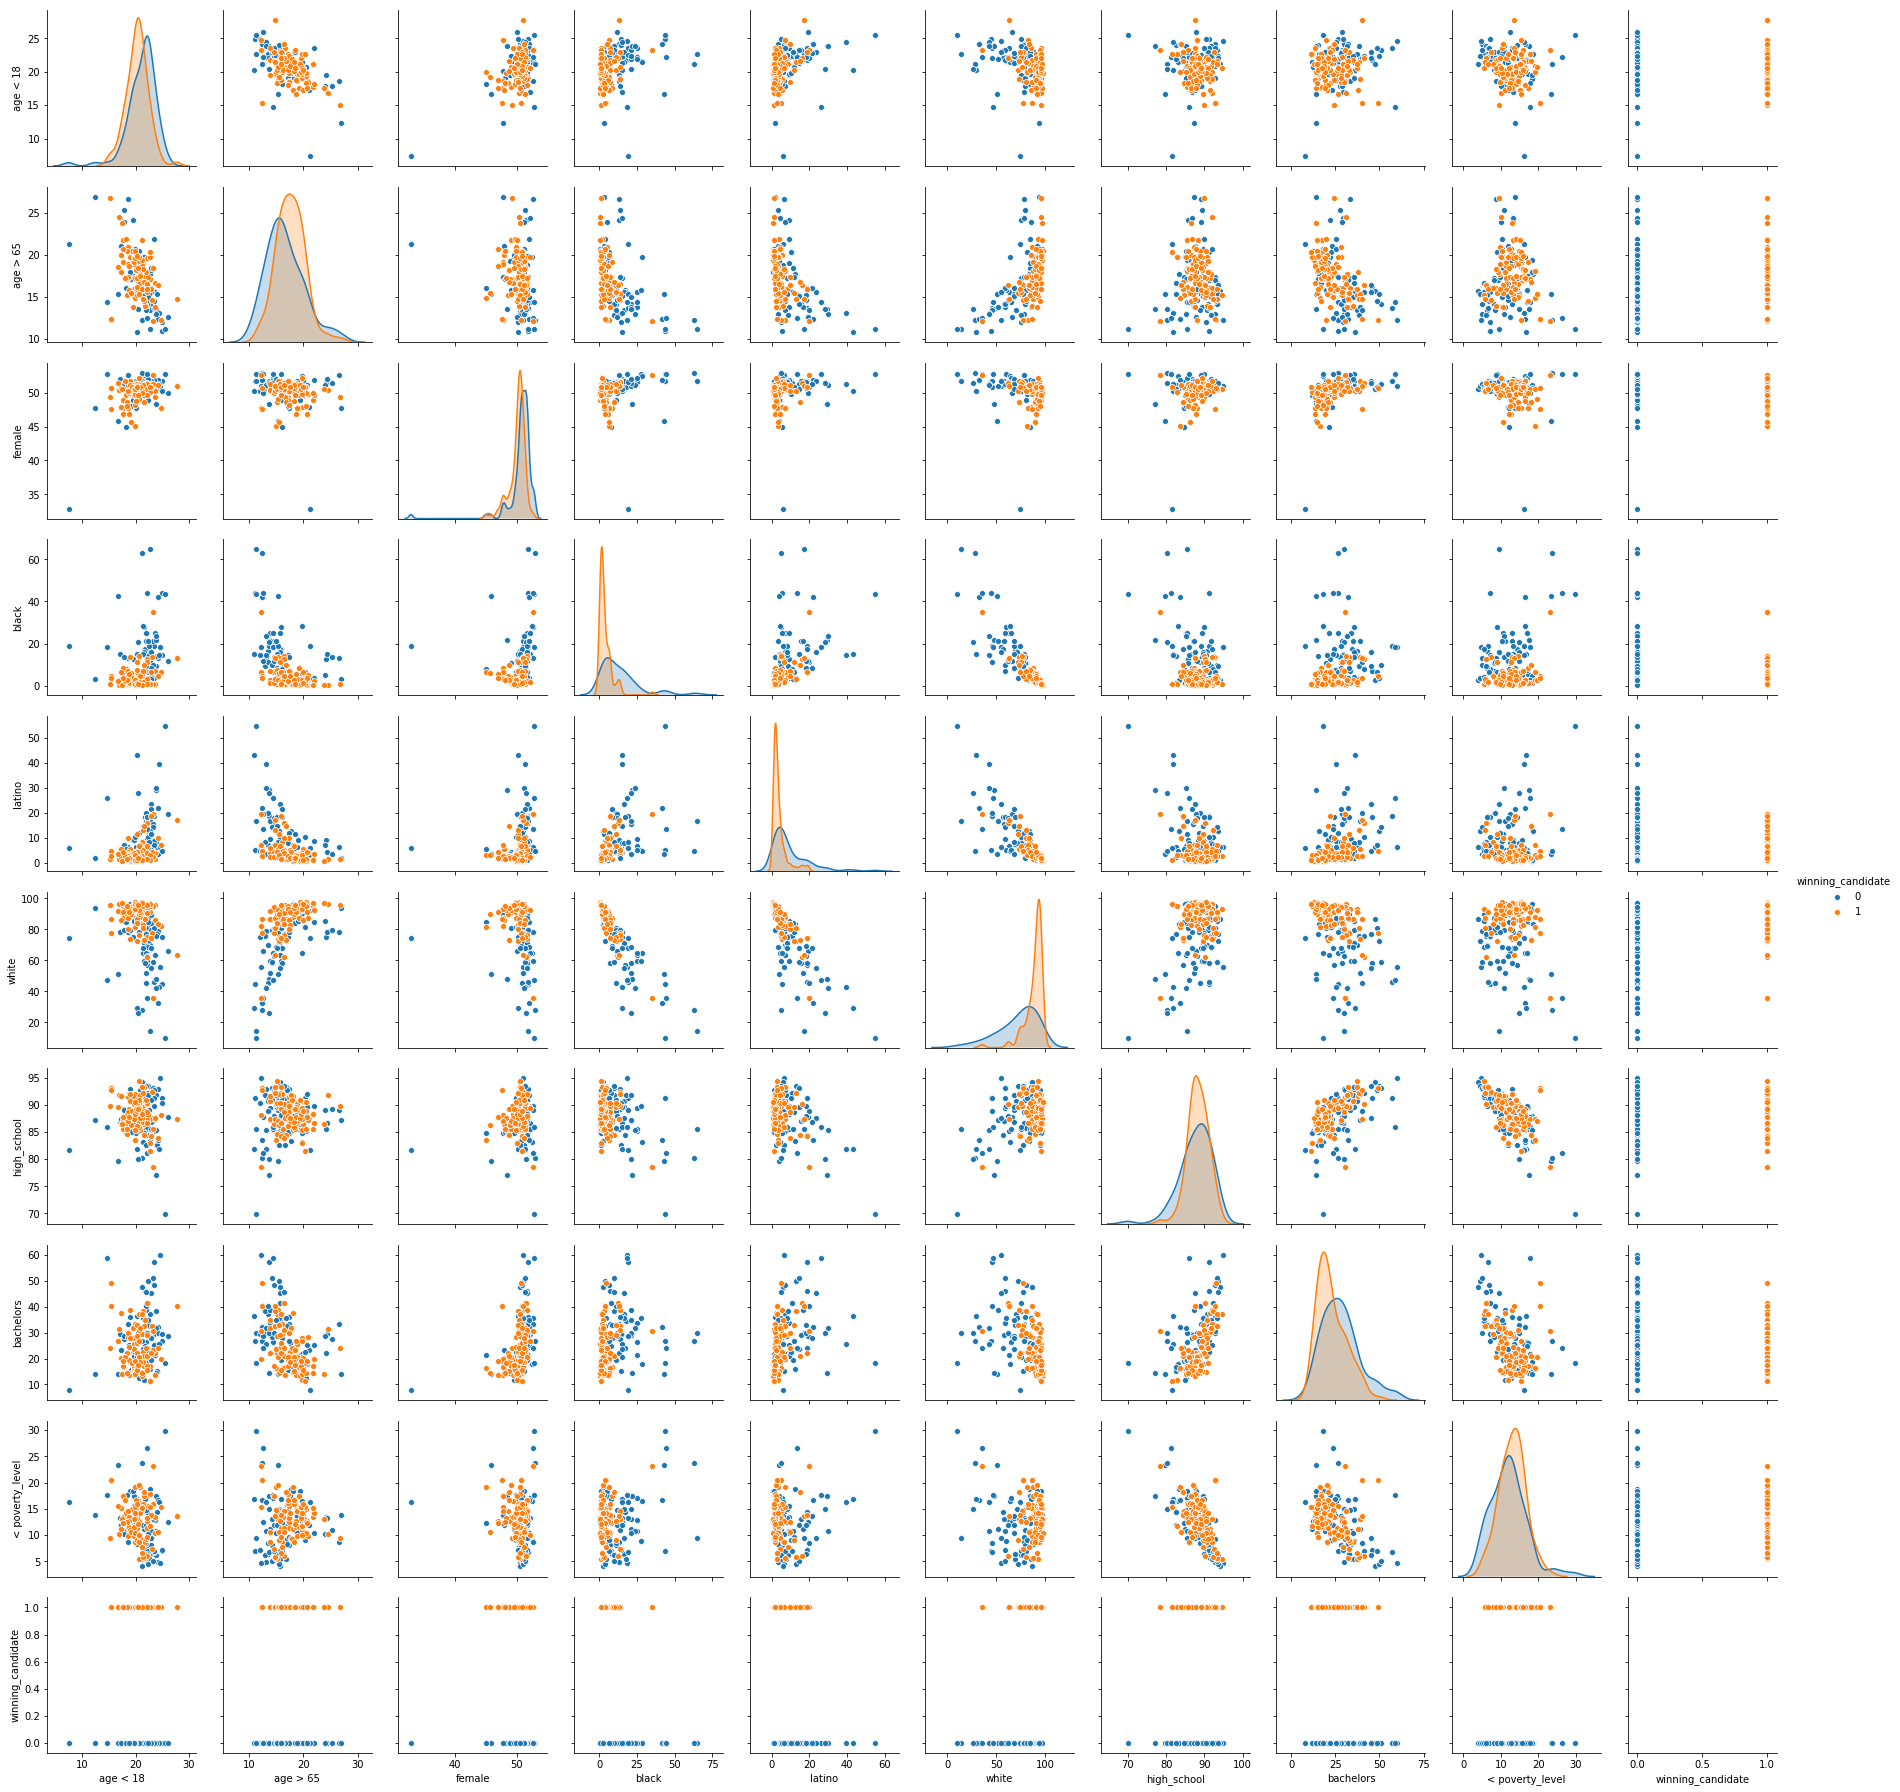

In [41]:
# Create train and test sets for Democratic data
d_x = county
d_y = winners
d_x_train, d_x_test, d_y_train, d_y_test = sklearn.model_selection.train_test_split(d_x, d_y, test_size=0.3)

# Show pair plot for Republican winners
pair_plot_winners(d_x, d_y)

Train Accuracy ::  0.9846153846153847
Test Accuracy  ::  0.7017543859649122


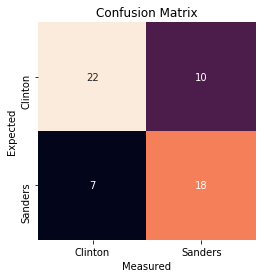

In [42]:
# Create random forest model and get best feature
bf = rf(d_x_train, d_y_train, d_x_test, d_y_test, features, candidates)

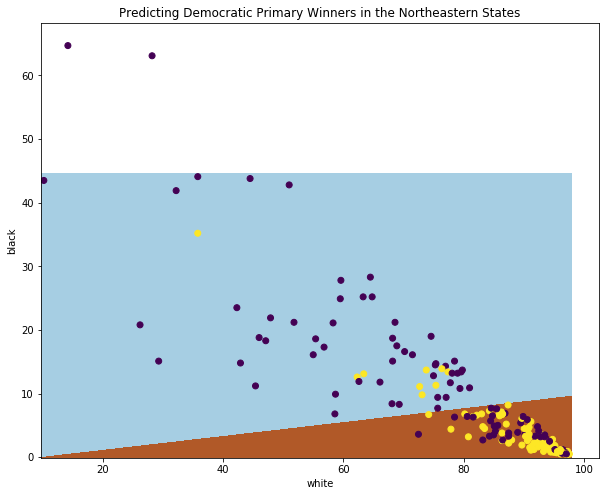

In [43]:
# Create a logistic regressor to show how the model "sees" the data
# Plot data on the two best features
d_title = "Predicting Democratic Primary Winners in the Northeastern States"
logistic_regressor_plot(bf[0], bf[1], d_x_train, d_y_train, d_x, d_y, d_title)

### Midwestern States

In [44]:
# Get county data for midwestern states
c = county_demo.state_abbreviation
mw_county_demo = county_demo[(c == "IN") | (c == "IA") | (c == "MI") | (c == "MO") | (c == "NE") | 
                             (c == "OH") | (c == "SD") | (c == "WI") | (c == "WV")]
county = mw_county_demo[features]

# Get desired primary data for midwestern states
# NOTE: omitted bc there was missing data for some of the counties:
# Illinois (IL)
# Minnesota (MN)
# North Dakota (ND)

p = primary_results.state_abbreviation
primary = primary_results[(p == "IN") | (p == "IA") | (p == "MI") | (p == "MO") | (p == "NE") | 
                          (p == "OH") | (p == "SD") | (p == "WI") | (p == "WV")]

# Get primary data on Democratic votes
pr = primary[primary["party"] == "Democrat"]

pr_clinton = pr[pr["candidate"] == "Hillary Clinton"]
pr_sanders = pr[pr["candidate"] == "Bernie Sanders"]

# If the candidates' data are not equal in size, there is data missing
if (len(pr_clinton) != len(pr_sanders)):
    print("ERROR: missing candidate data")
    print(len(pr_clinton), len(pr_sanders))
    
# Get Democratic winner from each county
winners = get_winners_democrat(pr_clinton, pr_sanders)

# Check that county data size matches the winners data size
if (len(county) != len(winners)):
    print("ERROR: missing county or winners data")
    print(len(county), len(winners))

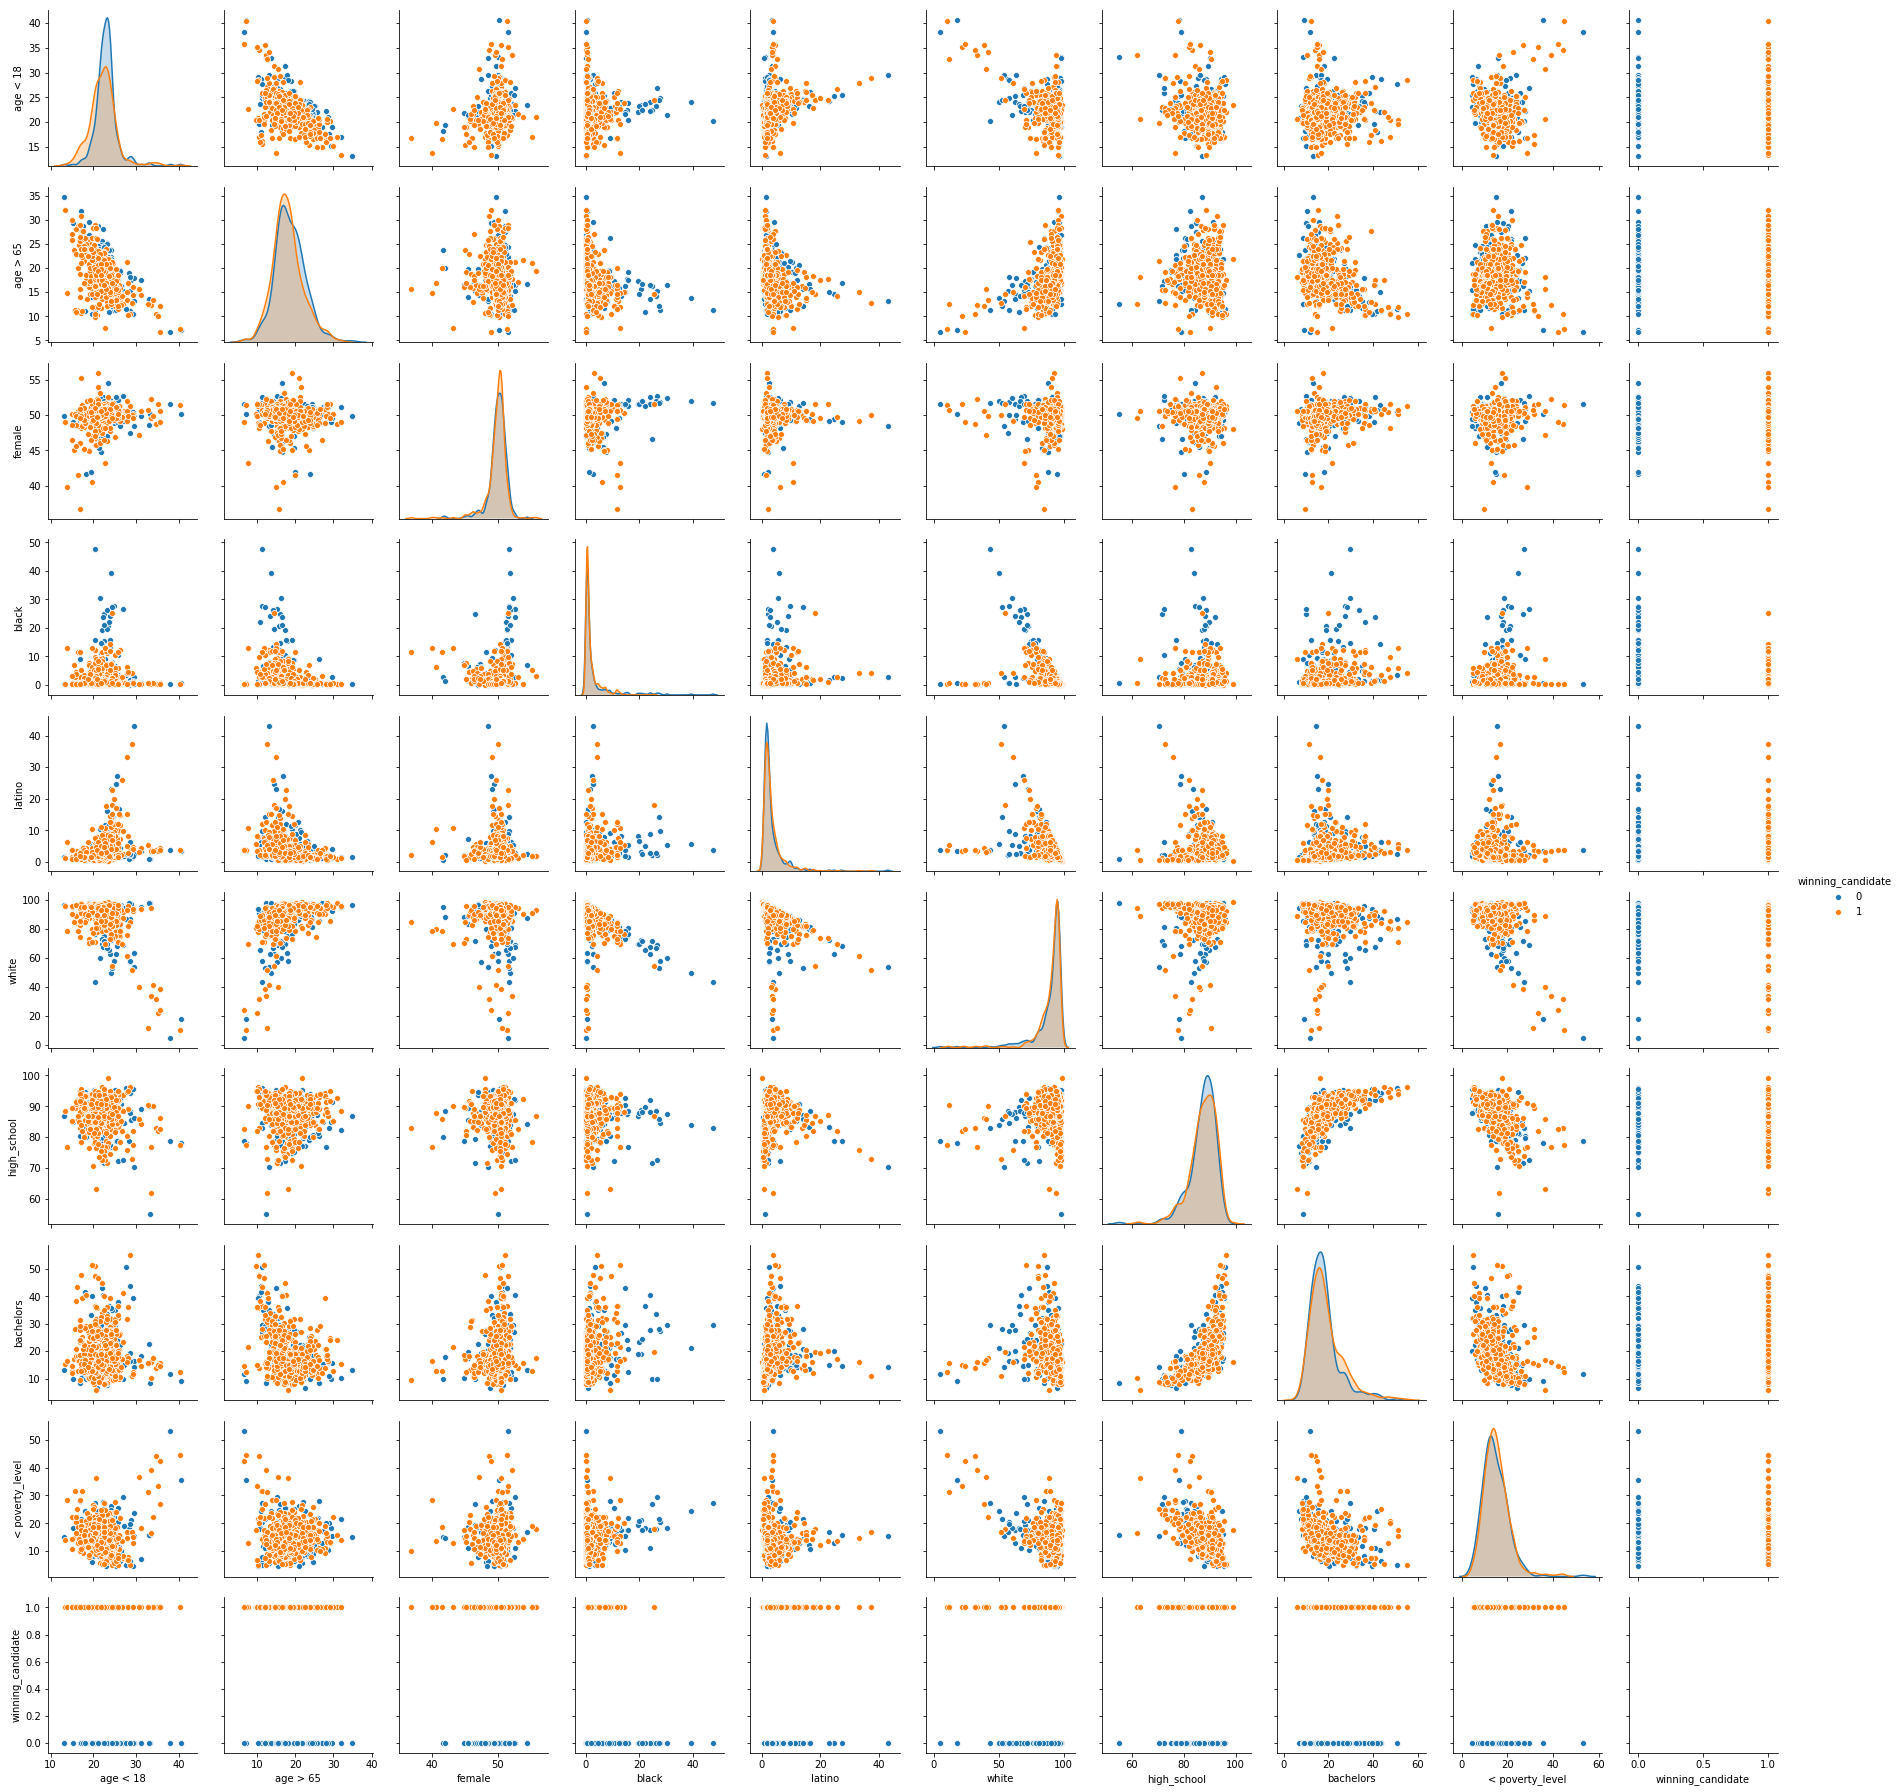

In [45]:
# Create train and test sets for Democratic data
d_x = county
d_y = winners
d_x_train, d_x_test, d_y_train, d_y_test = sklearn.model_selection.train_test_split(d_x, d_y, test_size=0.3)

# Show pair plot for Republican winners
pair_plot_winners(d_x, d_y)

Train Accuracy ::  0.9831460674157303
Test Accuracy  ::  0.6375545851528385


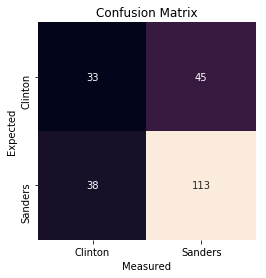

In [46]:
# Create random forest model and get best feature
bf = rf(d_x_train, d_y_train, d_x_test, d_y_test, features, candidates)

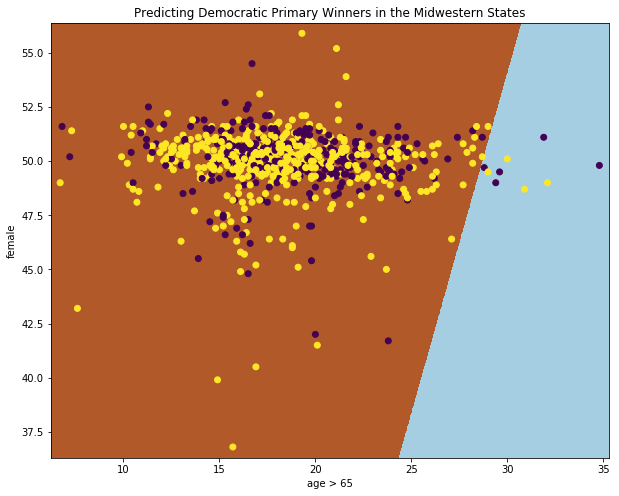

In [47]:
# Create a logistic regressor to show how the model "sees" the data
# Plot data on the two best features
d_title = "Predicting Democratic Primary Winners in the Midwestern States"
logistic_regressor_plot(bf[0], bf[1], d_x_train, d_y_train, d_x, d_y, d_title)

### Western States

In [48]:
# Get county data for western states
c = county_demo.state_abbreviation
w_county_demo = county_demo[(c == "AZ") | (c == "CA") | (c == "ID") | (c == "MT") | (c == "NV") | 
                            (c == "NM") | (c == "OR") | (c == "UT") | (c == "WA")]
county = w_county_demo[features]

# Get desired primary data for western states
# NOTE: omitted bc there was missing data for some of the counties:
# Alaska (AK)
# Colorado (CO)
# Hawaii (HI)
# Wyoming (WY)

p = primary_results.state_abbreviation
primary = primary_results[(p == "AZ") | (p == "CA") | (p == "ID") | (p == "MT") | (p == "NV") | 
                          (p == "NM") | (p == "OR") | (p == "UT") | (p == "WA")]

# Get primary data on Democratic votes
pr = primary[primary["party"] == "Democrat"]

pr_clinton = pr[pr["candidate"] == "Hillary Clinton"]
pr_sanders = pr[pr["candidate"] == "Bernie Sanders"]

# If the candidates' data are not equal in size, there is data missing
if (len(pr_clinton) != len(pr_sanders)):
    print("ERROR: missing candidate data")
    print(len(pr_clinton), len(pr_sanders))
    
# Get Democratic winner from each county
winners = get_winners_democrat(pr_clinton, pr_sanders)

# Check that county data size matches the winners data size
if (len(county) != len(winners)):
    print("ERROR: missing county or winners data")
    print(len(county), len(winners))

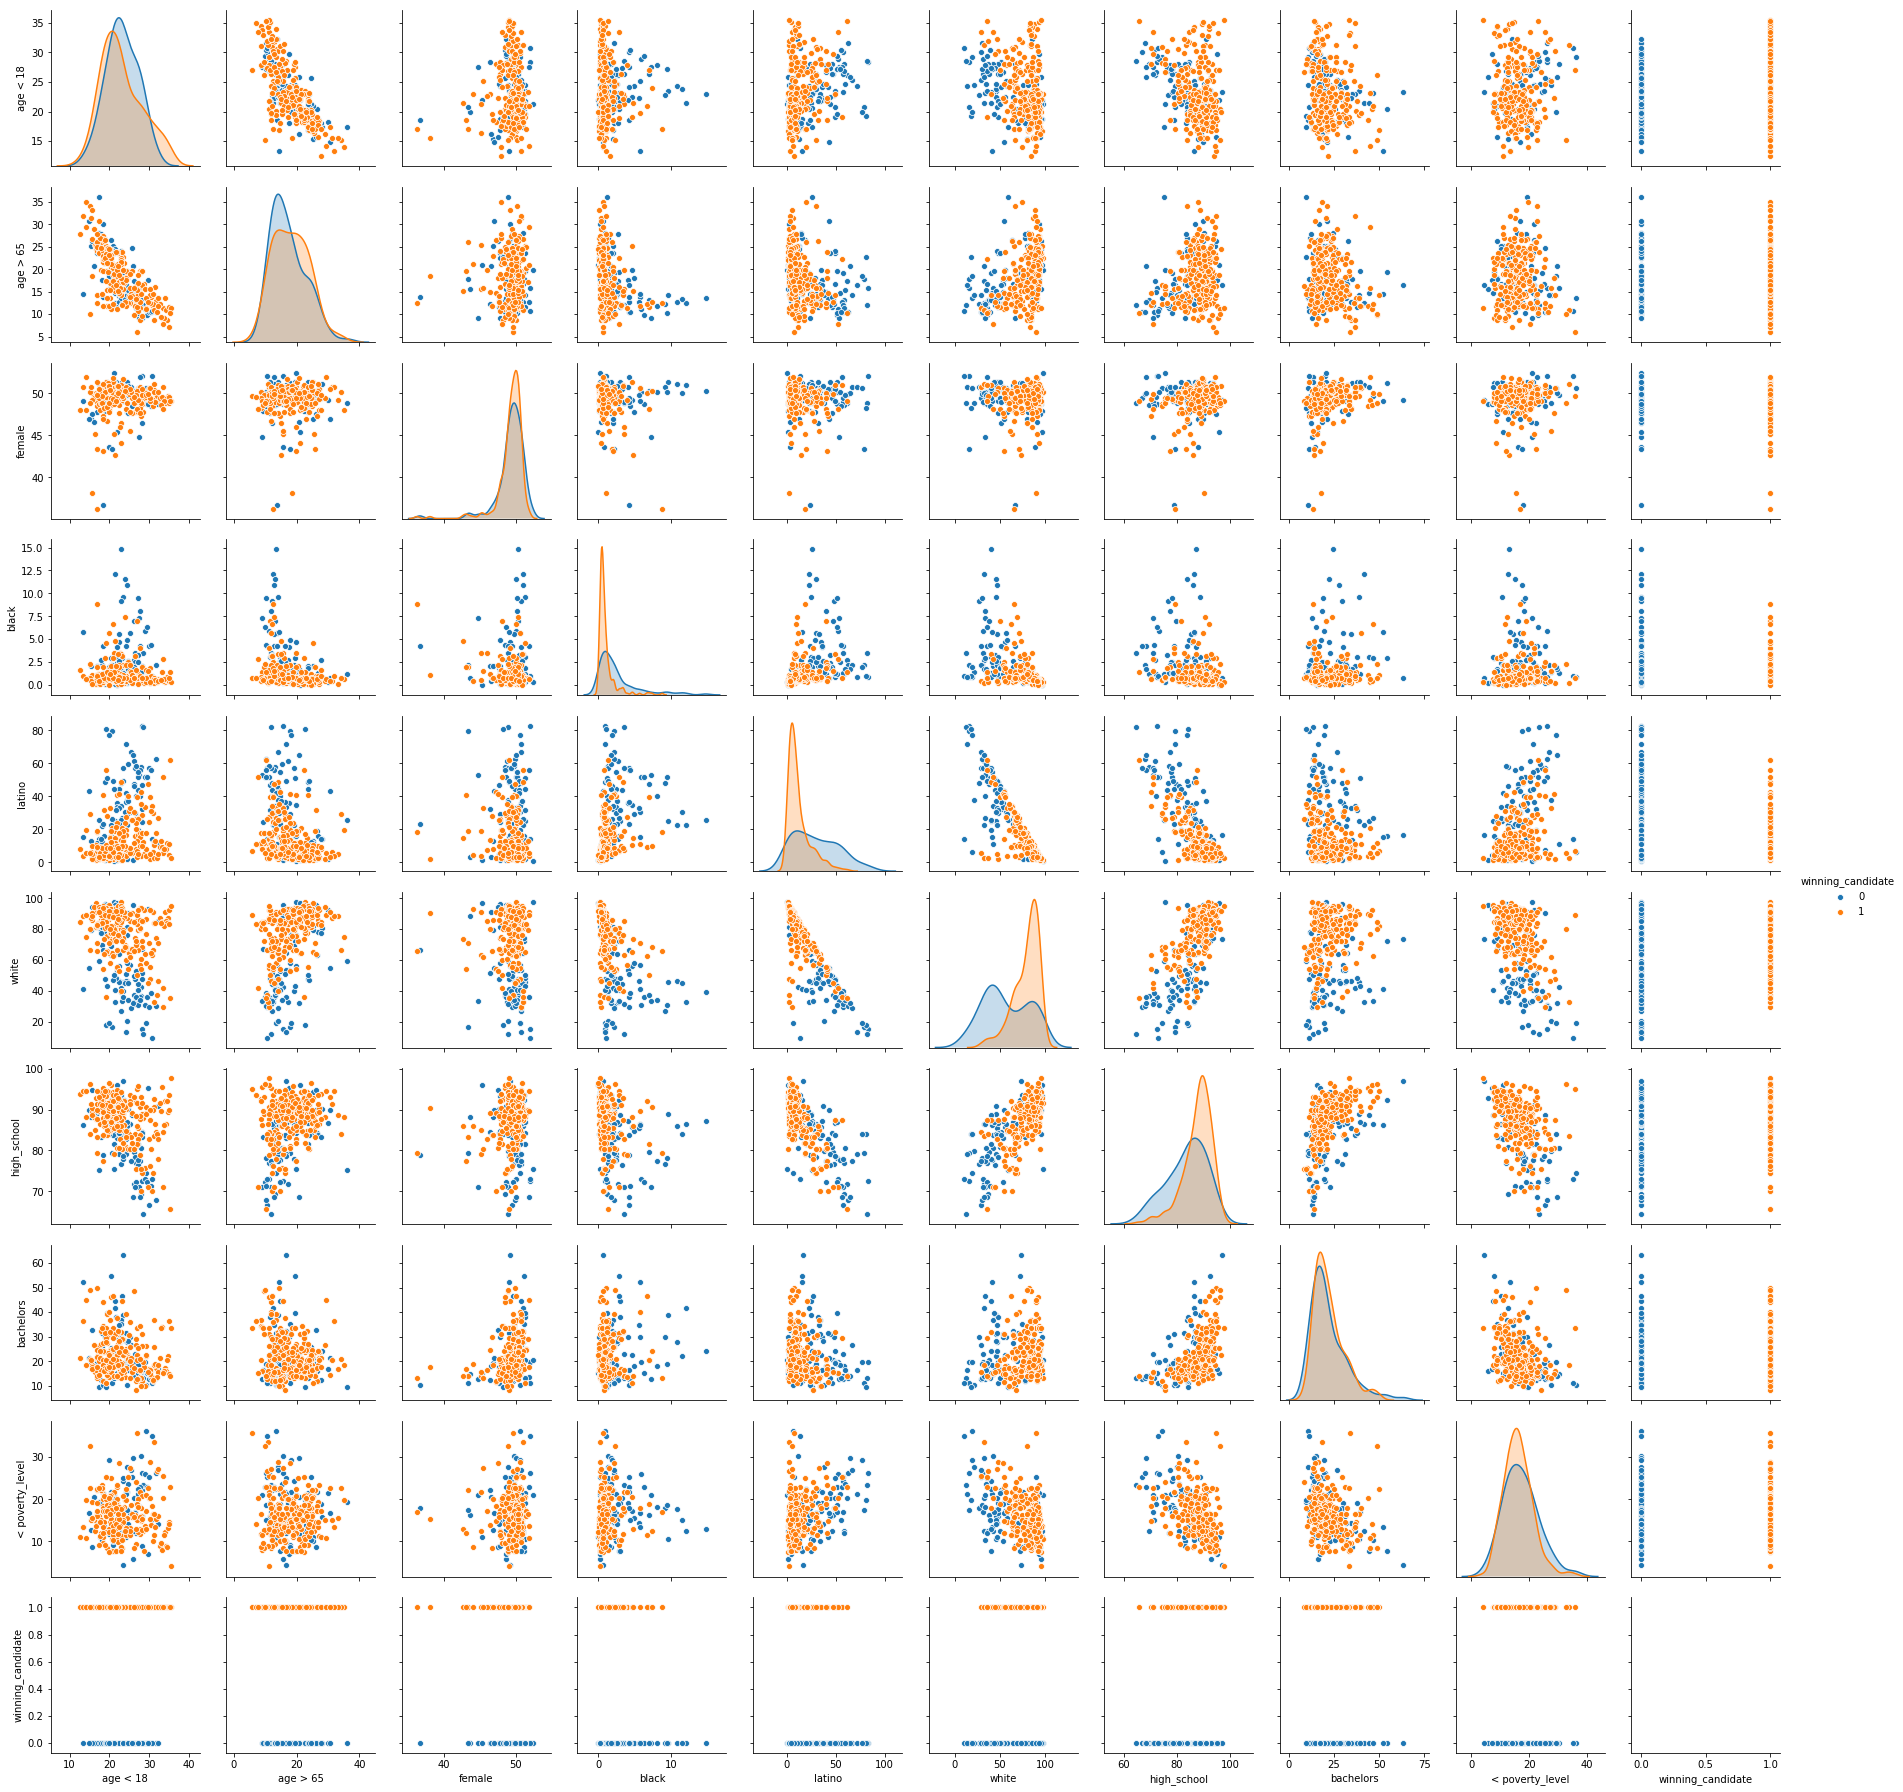

In [49]:
# Create train and test sets for Democratic data
d_x = county
d_y = winners
d_x_train, d_x_test, d_y_train, d_y_test = sklearn.model_selection.train_test_split(d_x, d_y, test_size=0.3)

# Show pair plot for Republican winners
pair_plot_winners(d_x, d_y)

Train Accuracy ::  0.9912280701754386
Test Accuracy  ::  0.7878787878787878


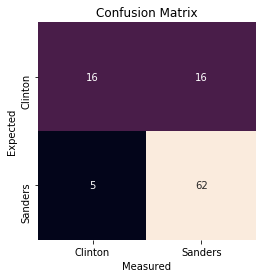

In [52]:
# Create random forest model and get best feature
bf = rf(d_x_train, d_y_train, d_x_test, d_y_test, features, candidates)

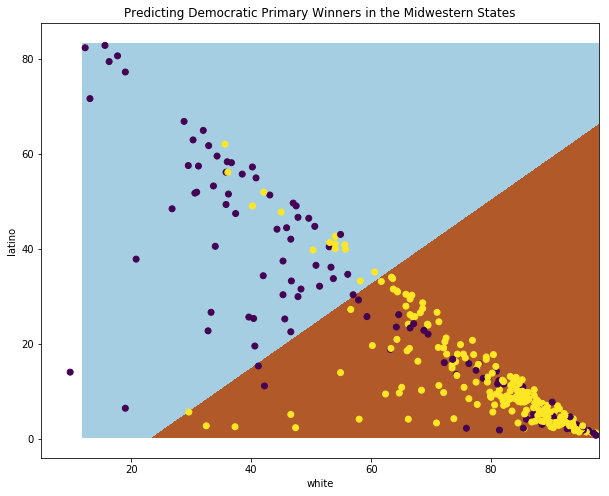

In [53]:
# Create a logistic regressor to show how the model "sees" the data
# Plot data on the two best features
d_title = "Predicting Democratic Primary Winners in the Midwestern States"
logistic_regressor_plot(bf[0], bf[1], d_x_train, d_y_train, d_x, d_y, d_title)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

# create the map
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

# load the shapefile, use the name 'states'
map.readshapefile('st99_d00', name='states', drawbounds=True)

# collect the state names from the shapefile attributes so we can
# look up the shape obect for a state by it's name
state_names = []
for shape_dict in map.states_info:
    state_names.append(shape_dict['NAME'])

ax = plt.gca() # get current axes instance

# get Texas and draw the filled polygon
seg = map.states[state_names.index('Texas')]
poly = Polygon(seg, facecolor='red',edgecolor='red')
ax.add_patch(poly)

plt.show()

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'